# Libraries and loading in the data

In [1]:
import xarray as xr
import os
import numpy as np
import matplotlib.animation as anim
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd

In [2]:
experiment = os.path.join('experiments', 'first_draft')

In [3]:
from pathlib import Path

class Paths:
    pass

paths = Paths()

paths.base = Path(experiment)
paths.models = Path(os.path.join(experiment, 'models'))
paths.locations = Path(os.path.join(experiment, 'models', 'locations'))
paths.figures = Path(os.path.join(experiment, 'figures'))
paths.lme_models = Path(os.path.join(experiment, 'lme'))

for path in paths.__dict__.values():
    path.mkdir(parents=True, exist_ok=True)

In [4]:
plt.style.use('/Users/kyle/GoogleDrive/personal.mplstyle')

In [5]:
xr.set_options(keep_attrs=True)
pd.options.display.float_format = '{:.2f}'.format

In [6]:
with xr.open_dataset(os.path.join('data', 'MERRA-2', 'Texas', 'merged-all-products-daily-averages-clipped.nc4')) as ds:
    ds.load()

ds['PM2.5'] = np.log(ds['PM2.5'] * 1e9)
ds['AODANA'] = np.log(ds['AODANA'])
ds['MonthCos'] = np.cos(np.pi * 2 * ds.time.dt.month / 12)
ds['MonthSin'] = np.sin(np.pi * 2 * ds.time.dt.month / 12)
ds

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/xarray/core/computation.py:739: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


<xarray.Dataset>
Dimensions:      (lat: 22, lon: 21, time: 4018)
Coordinates:
  * lat          (lat) float64 26.0 26.5 27.0 27.5 28.0 ... 35.0 35.5 36.0 36.5
  * lon          (lon) float64 -106.2 -105.6 -105.0 ... -95.0 -94.38 -93.75
  * time         (time) datetime64[ns] 2010-01-01 2010-01-02 ... 2020-12-31
    spatial_ref  int64 0
Data variables: (12/119)
    LWGAB        (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    CLDTOT       (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    ALBNIRDF     (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    SWTDN        (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    EMIS         (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    LWTUPCLRCLN  (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    ...           ...
    T2MMAX       (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    T2MMEAN      (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    T2MMIN       (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    TPRECMAX     (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    MonthCos     (time) float64 0.866 0.866 0.866 0.866 ... 1.0 1.0 1.0 1.0
    MonthSin     (time) float64 0.5 0.5 0.5 ... -2.449e-16 -2.449e-16 -2.449e-16

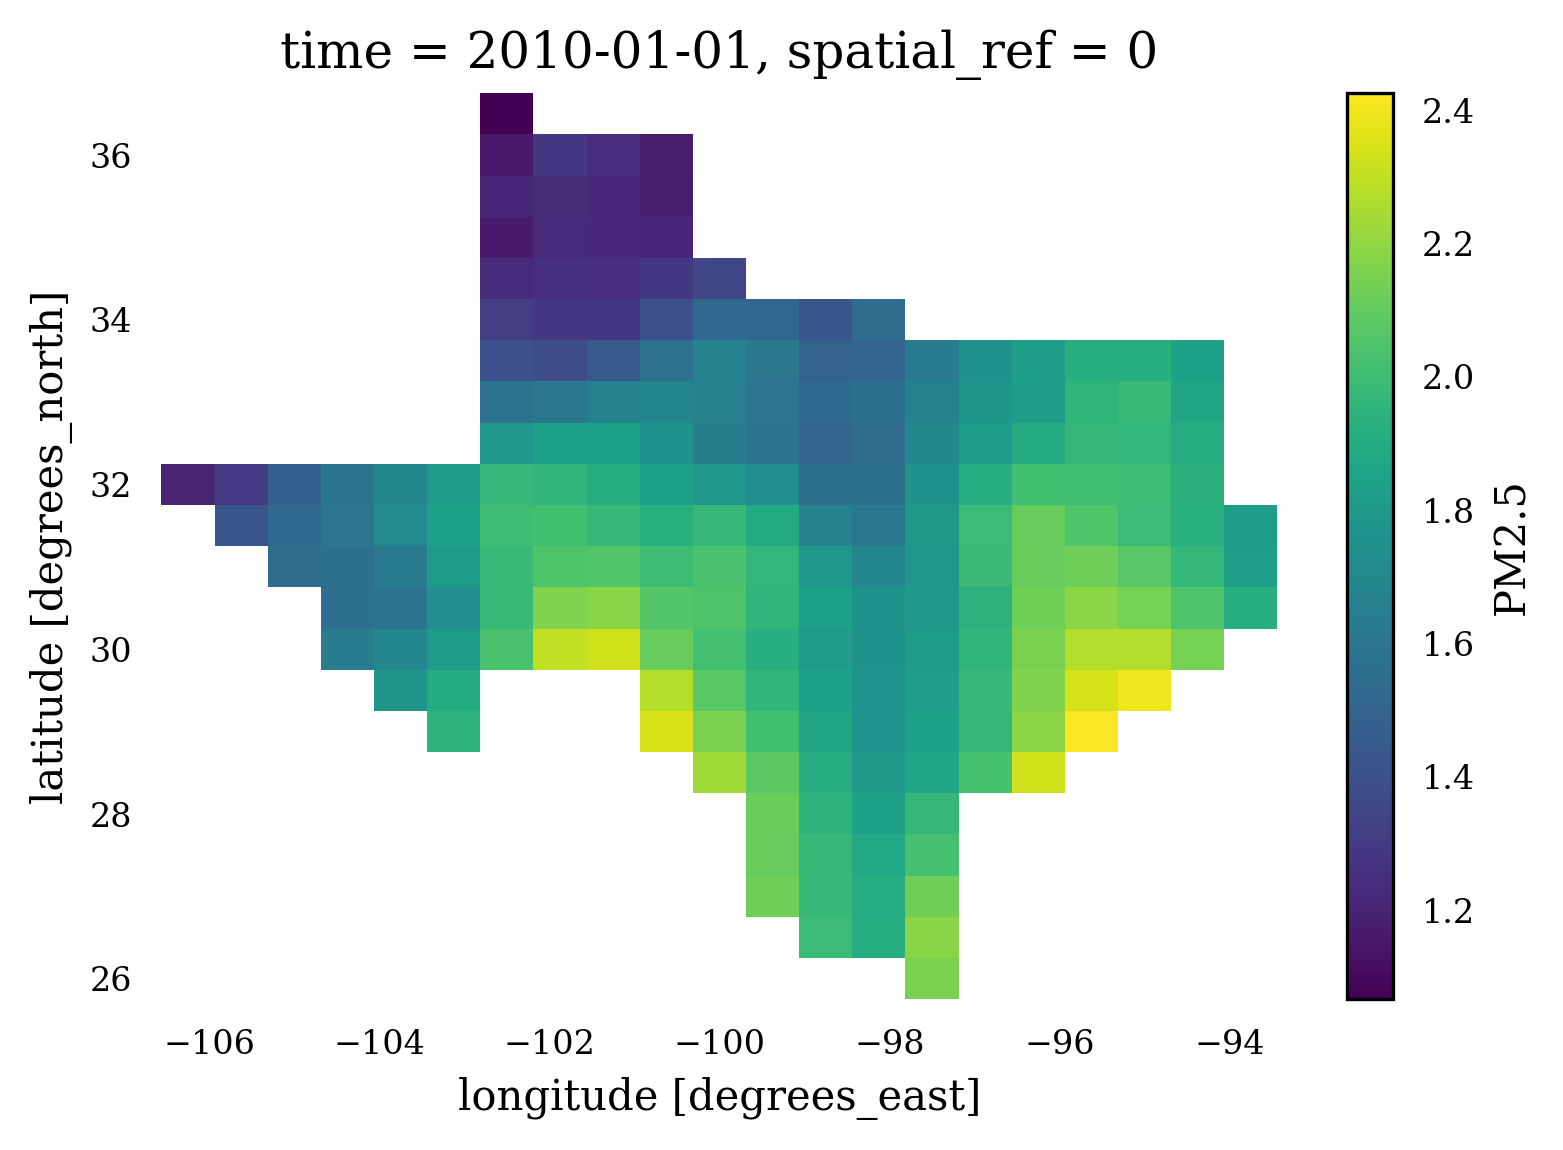

In [7]:
fig, ax = plt.subplots(dpi=300)

ds["PM2.5"][0].plot(ax=ax)

# Feature Selection

120 features is far too many features. Further, some of the columns make up the PM2.5 column and many are not directly measurable by ground stations. The goal of this project is to work on data reminiscent of ground data and then compare the performance of several of the algorithms across the same time and spatial domain with the same features. A future study could then replicate the results but with data measured with satellites and weather stations.

Here, we will pick out a subset of the variables which are directly measurable and then choose the top `n` features with the highest mutual information value. There is no fundamental reason that we chose mutual information over Pearson's R.

First we will need to cut down the data to those columns that we need, split into the testing, training, and validation sets, and then run feature selection. The feature selection will be run only on the training set. The columns kept from the training set will be applied to the validation and testing sets.

A note on the train, test, validation split: The atmosphere has a memory. One can imagine that the concentration of PM2.5 on a Monday might affect the concentration on a Tuesday. Similar things can be said for other data variables. I do not know how, but it is possible that somehow some of the algorithms could learn a correlation between these variables, depending on which time componenet is used. To prevent the learned estimators from cheating when predicting the testing data, I wanted to ensure that there was space in time between the training and testing sets. That is why I did not use the normal `train_test_split` function provided by `scikit-learn`. Further, the validation set here is used only to check the out-of-sample performance **after** the algorithms are trained, meaning this validation set is not used in any of the algorithms. It is possible that some of the algorithms use a validation set, but that set would be a subset of the training set. Because the validation set made here is used to check the out-of-sample performance, it is possible that some of the actions taken could be influenced by those values, so the validation set should be considered to be a part of the training set. The final values reported at the end of this study will be reported on the testing set. The testing set will be run *exactly* once.

In [8]:
features_to_keep = [
    'PS',
    'QV2M',
    'QV10M',
    'T2M',
    'T10M',
    'U2M',
    'V2M',
    'U50M',
    'V50M',
    'U10M',
    'V10M',
    'TQL',
    'TQI',
    'TQV',
    'CLDTOT',
    'PM2.5',
    'AODANA',
    'ALBEDO',
    'TS',
    'MonthSin',
    'MonthCos',
    'TPRECMAX',
    'DISPH',
    'EMIS'
    ]

In [9]:
df = ds[features_to_keep]
df

<xarray.Dataset>
Dimensions:      (lat: 22, lon: 21, time: 4018)
Coordinates:
  * lat          (lat) float64 26.0 26.5 27.0 27.5 28.0 ... 35.0 35.5 36.0 36.5
  * lon          (lon) float64 -106.2 -105.6 -105.0 ... -95.0 -94.38 -93.75
  * time         (time) datetime64[ns] 2010-01-01 2010-01-02 ... 2020-12-31
    spatial_ref  int64 0
Data variables: (12/24)
    PS           (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    QV2M         (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    QV10M        (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    T2M          (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    T10M         (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    U2M          (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    ...           ...
    TS           (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    MonthSin     (time) float64 0.5 0.5 0.5 ... -2.449e-16 -2.449e-16 -2.449e-16
    MonthCos     (time) float64 0.866 0.866 0.866 0.866 ... 1.0 1.0 1.0 1.0
    TPRECMAX     (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    DISPH        (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    EMIS         (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan

In [10]:
train = df.sel(time=slice("2010", "2017")).to_dataframe().reset_index().set_index('time').drop(['spatial_ref'], axis=1)
val = df.sel(time=slice("2018", "2019-06")).to_dataframe().reset_index().set_index('time').drop(['spatial_ref'], axis=1)
test = df.sel(time=slice("2019-07", "2020")).to_dataframe().reset_index().set_index('time').drop(['spatial_ref'], axis=1)

Because the dataset was clipped to Texas, there are a lot of NaNs. We can just drop those since those are for location that are not in Texas.


In [11]:
train = train.dropna()
val = val.dropna()
test = test.dropna()
train.head()

,lat,lon,PS,QV2M,QV10M,T2M,T10M,U2M,V2M,U50M,...,CLDTOT,PM2.5,AODANA,ALBEDO,TS,MonthSin,MonthCos,TPRECMAX,DISPH,EMIS
time,,,,,,,,,,,,,,,,,,,,,
2010-01-01,26.00,-97.50,102550.84,0.01,0.01,286.15,286.14,1.17,-4.50,1.90,...,0.70,2.15,-2.30,0.17,286.53,0.50,0.87,0.00,0.17,0.97
2010-01-02,26.00,-97.50,102471.00,0.01,0.01,285.52,286.11,-1.47,-0.55,-2.82,...,0.77,1.83,-2.17,0.16,285.80,0.50,0.87,0.00,0.17,0.97
2010-01-03,26.00,-97.50,101837.12,0.01,0.01,289.48,289.97,-0.82,0.06,-2.22,...,0.84,1.98,-1.76,0.16,289.42,0.50,0.87,0.00,0.17,0.97
2010-01-04,26.00,-97.50,102421.00,0.01,0.01,287.70,287.63,-0.90,-4.72,-1.78,...,0.87,2.66,-1.52,0.16,288.01,0.50,0.87,0.00,0.17,0.97
2010-01-05,26.00,-97.50,102816.41,0.01,0.01,284.08,284.30,-1.30,-2.23,-2.58,...,0.61,2.00,-2.10,0.17,284.90,0.50,0.87,0.00,0.17,0.97


In [12]:
from sklearn.feature_selection import mutual_info_regression, SelectKBest

def make_feature_selector(df, endogenous, k=15):
    """ Create a SelectKBest model for the dataset
    
    Parameters
    ----------
    df : pandas.DataFrame
        The dataframe holding the exogenous (independent) and endogenous (dependent) variables
    endogenous: str
        A string indicating which variable is the endogenous (dependent) variable
    k: int, default 15
        The number of desired features (columns of the dataframe, exogenous variables) to keep

    Returns
    ----------
    features: sklearn.feature_selection.SelectKBest
        A fitted SelectKBest model
    """
    X, y = df.drop(endogenous, axis=1), df[endogenous]
    features = SelectKBest(mutual_info_regression, k=k)
    features.fit(X, y)
    return features

def subset_features(df, features):
    """ Extract the desired features from a dataframe
    
    Parameters
    ----------
    df : a pandas dataframe
        The dataframe holding the exogenous (independent) variables and excluding the endogenous (dependent) variable
    features: sklearn.feature_selection._BaseFilter
        A fitted sklearn.feature_selection._BaseFilter like SelectKBest

    Returns
    ----------
    X: pandas.DataFrame
        A subset of `df` containing only those features selected by `features`
    """
    
    return df.loc[:, features.get_support()]

In [13]:
import pickle

feature_file = os.path.join(paths.models, 'feature_selection.pcl')

if os.path.exists(feature_file):
    with open(feature_file, 'rb') as f:
        features = pickle.load(f)
else:
    features = make_feature_selector(train, 'PM2.5', k=10)
    with open(feature_file, 'wb') as f:
        pickle.dump(features, f)

In [14]:
x_train, y_train = subset_features(train.drop('PM2.5', axis=1), features), train['PM2.5']

In [15]:
x_val, y_val = subset_features(val.drop('PM2.5', axis=1), features), val['PM2.5']

In [16]:
x_test, y_test = subset_features(test.drop('PM2.5', axis=1), features), test['PM2.5']

# Colorbar creation, Importing Utilities, Plotting Functions

In [250]:
import importlib
import sys
importlib.reload(sys.modules['plotting'])

from utils import summarize_scores, scores_from_model_collection_predictions

from plotting import \
    residuals_plot, \
    score_boxplot, \
    grouped_boxplot_with_table, \
    plot_prediction_error, \
    feature_importance, \
    histogram_density_plot, \
    set_size, \
    map_predicted

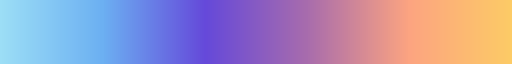

In [18]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm

# https://matplotlib.org/stable/tutorials/colors/colormap-manipulation.html#directly-creating-a-segmented-colormap-from-a-list
colors = ["#9CDEF6", "#6CB0F2", "#6549DA", "#A86CAD", "#FCA481", "#FDCB66"]
announce = LinearSegmentedColormap.from_list("Announce", colors)
announce

# Modeling

## Training

### Training

In [227]:
import importlib
import sys
importlib.reload(sys.modules['model_collection'])
from model_collection import ModelCollection, ModelStack

In [22]:
lme_group = 'Season'
formula = f'PM ~ QV2M + QV10M + T2M + T10M + TQV + AODANA + (1 + AODANA|Location/{lme_group}) + ALBEDO + TS + MonthCos + DISPH'

locations = train['lat'].astype(str) + train['lon'].astype(str)
locations.name = 'Location'

mc = ModelCollection(
    x_train, y_train, 
    lme_dependent='PM', 
    lme_formula=formula, 
    lme_group=lme_group, 
    lme_locations=locations)


In [23]:
cv_scores = mc.compute_cross_validation_scores()

  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[20:29:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:29:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:29:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:30:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:30:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:31:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:31:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:32:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:32:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

In [24]:
fit_times = mc.fit()

  0%|          | 0/15 [00:00<?, ?it/s]

boundary (singular) fit: see ?isSingular 

Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Location/Season)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 604854	 Groups: {'Season:Location': 828.0, 'Location': 207.0}

Log-likelihood: -156083.863 	 AIC: 312167.727

Random effects:

                        Name  Var  Std
Season:Location  (Intercept) 0.02 0.13
Season:Location       AODANA 0.01 0.07
Location         (Intercept) 0.01 0.07
Location              AODANA 0.00 0.02
Residual                     0.10 0.31

                         IV1     IV2  Corr
Season:Location  (Intercept)  AODANA  0.35
Location         (Intercept)  AODANA -1.00

Fixed effects:

[21:53:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [25]:
mc.save(os.path.join(paths.models, 'texas-2010-17.joblib'))

In [26]:
mc.save_model_cross_val_scores(os.path.join(paths.models, 'texas-2010-17_scores.p'))

In [31]:
# mc.load(os.path.join(paths.models, 'texas-2010-17.joblib'))

[10:16:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [67]:
# mc = ModelCollection.__new__(ModelCollection)
# mc.load_model_cross_val_scores(os.path.join(paths.models, 'texas-2010-17_scores.p'))

### MGWR

In [33]:
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW

In [34]:
gwr_x, gwr_y = train.loc['2010'][x_train.columns.values.tolist() + ['lat', 'lon']], y_train.loc['2010']
coords = list(zip(gwr_x.lat, gwr_x.lon))
gwr_x = gwr_x.drop(['lat', 'lon'], axis=1)
gwr_x, gwr_y = gwr_x.values, gwr_y.values.reshape(-1, 1)

In [35]:
def is_invertible(a):
    return a.shape[0] == a.shape[1] and np.linalg.matrix_rank(a) == a.shape[0]

In [36]:
# bw = Sel_BW(coords[:1000], gwr_y[:1000], gwr_x[:1000], fixed=True, spherical=True).search(criterion='AICc')
# print(bw)

In [37]:
# https://mgwr.readthedocs.io/en/latest/generated/mgwr.gwr.GWR.html#mgwr.gwr.GWR

# model = GWR(coords, gwr_y, gwr_x, bw=bw, fixed=True, kernel='gaussian')
# results = model.fit()

In [38]:
# results.summary()

### Linear Mixed Effect Things

In [39]:
def lme_experiment(x_train, y_train, locations, formula, model_file, scores_file):
    mc = ModelCollection(
        x_train, y_train, 
        lme_dependent='PM', 
        lme_formula=formula, 
        lme_group=lme_group, 
        lme_locations=locations)

    mc.fit_model('Linear Mixed Effect')
    mc.save(model_file)

    mc.compute_cross_validation_scores_for_model('Linear Mixed Effect')
    mc.save_model_cross_val_scores(scores_file)

locations = train['lat'].astype(str) + train['lon'].astype(str)
locations.name = 'Location'

for feature in ['AODANA', 'TQV', 'T2M', 'QV10M']:
    for lme_group in ['DoY', 'Month', 'Season', 'Location']:
        formula = f'PM ~ QV2M + QV10M + T2M + T10M + TQV + (1 + {feature}|{lme_group}) + AODANA + ALBEDO + TS + MonthCos + DISPH'

        fname = os.path.join(paths.lme_models, f'{feature}_{lme_group}')
        lme_experiment(x_train, y_train, locations, formula, f'{fname}.joblib', f'{fname}.p')

for lme_group in ['DoY', 'Month', 'Season']:
    formula = f'PM ~ QV2M + QV10M + T2M + T10M + TQV + (1 + AODANA|Location/{lme_group}) + AODANA + ALBEDO + TS + MonthCos + DISPH'

    fname = os.path.join(paths.lme_models, f'nested_location_{lme_group}')
    lme_experiment(x_train, y_train, locations, formula, f'{fname}.joblib', f'{fname}.p')


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+(1+AODANA|DoY)+AODANA+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 604854	 Groups: {'DoY': 366.0}

Log-likelihood: -163071.886 	 AIC: 326143.772

Random effects:

                 Name  Var  Std
DoY       (Intercept) 0.02 0.13
DoY            AODANA 0.01 0.10
Residual              0.10 0.32

             IV1     IV2  Corr
DoY  (Intercept)  AODANA  0.17

Fixed effects:

Formula: PM~QV2M+QV10M+T2M+T10M+TQV+(1+AODANA|Month)+AODANA+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 604854	 Groups: {'Month': 12.0}

Log-likelihood: -182237.461 	 AIC: 364474.922

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.04 0.21
Month          AODANA 0.01 0.08
Residual              0.11 0.33

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.97

Fixed effects:

Formula: PM~QV2M+QV10M+T2M+T10M+TQV+(1+AODANA|Season)+AODANA+ALBEDO+TS+MonthCos+DISPH



In [43]:
cv_scores = {}

with open(os.path.join(paths.models, 'texas-2010-17_scores.p'), 'rb') as f: 
    global_scores = pickle.load(f)

for feature in ['AODANA', 'TQV', 'T2M', 'QV10M']:
    for lme_group in ['DoY', 'Month', 'Season', 'Location']:
        fname = os.path.join(paths.lme_models, f'{feature}_{lme_group}.p')

        with open(fname, 'rb') as f: 
            scores = pickle.load(f)
        title = lme_group.capitalize()
        if title == 'Doy':
            title = 'Day of Year'
        title = f'{feature} | {title}'
        cv_scores[title] = scores['Linear Mixed Effect']


for lme_group in ['DoY', 'Month', 'Season']:
    fname = os.path.join(paths.lme_models, f'nested_location_{lme_group}.p')

    with open(fname, 'rb') as f: 
        scores = pickle.load(f)
    title = lme_group.capitalize()
    if title == 'Doy':
        title = 'Day of Year'
    title = f'AODANA | Location / {title}'
    cv_scores[title] = scores['Linear Mixed Effect']

cv_scores['Global Regression'] = global_scores["Linear Regression"]    
    

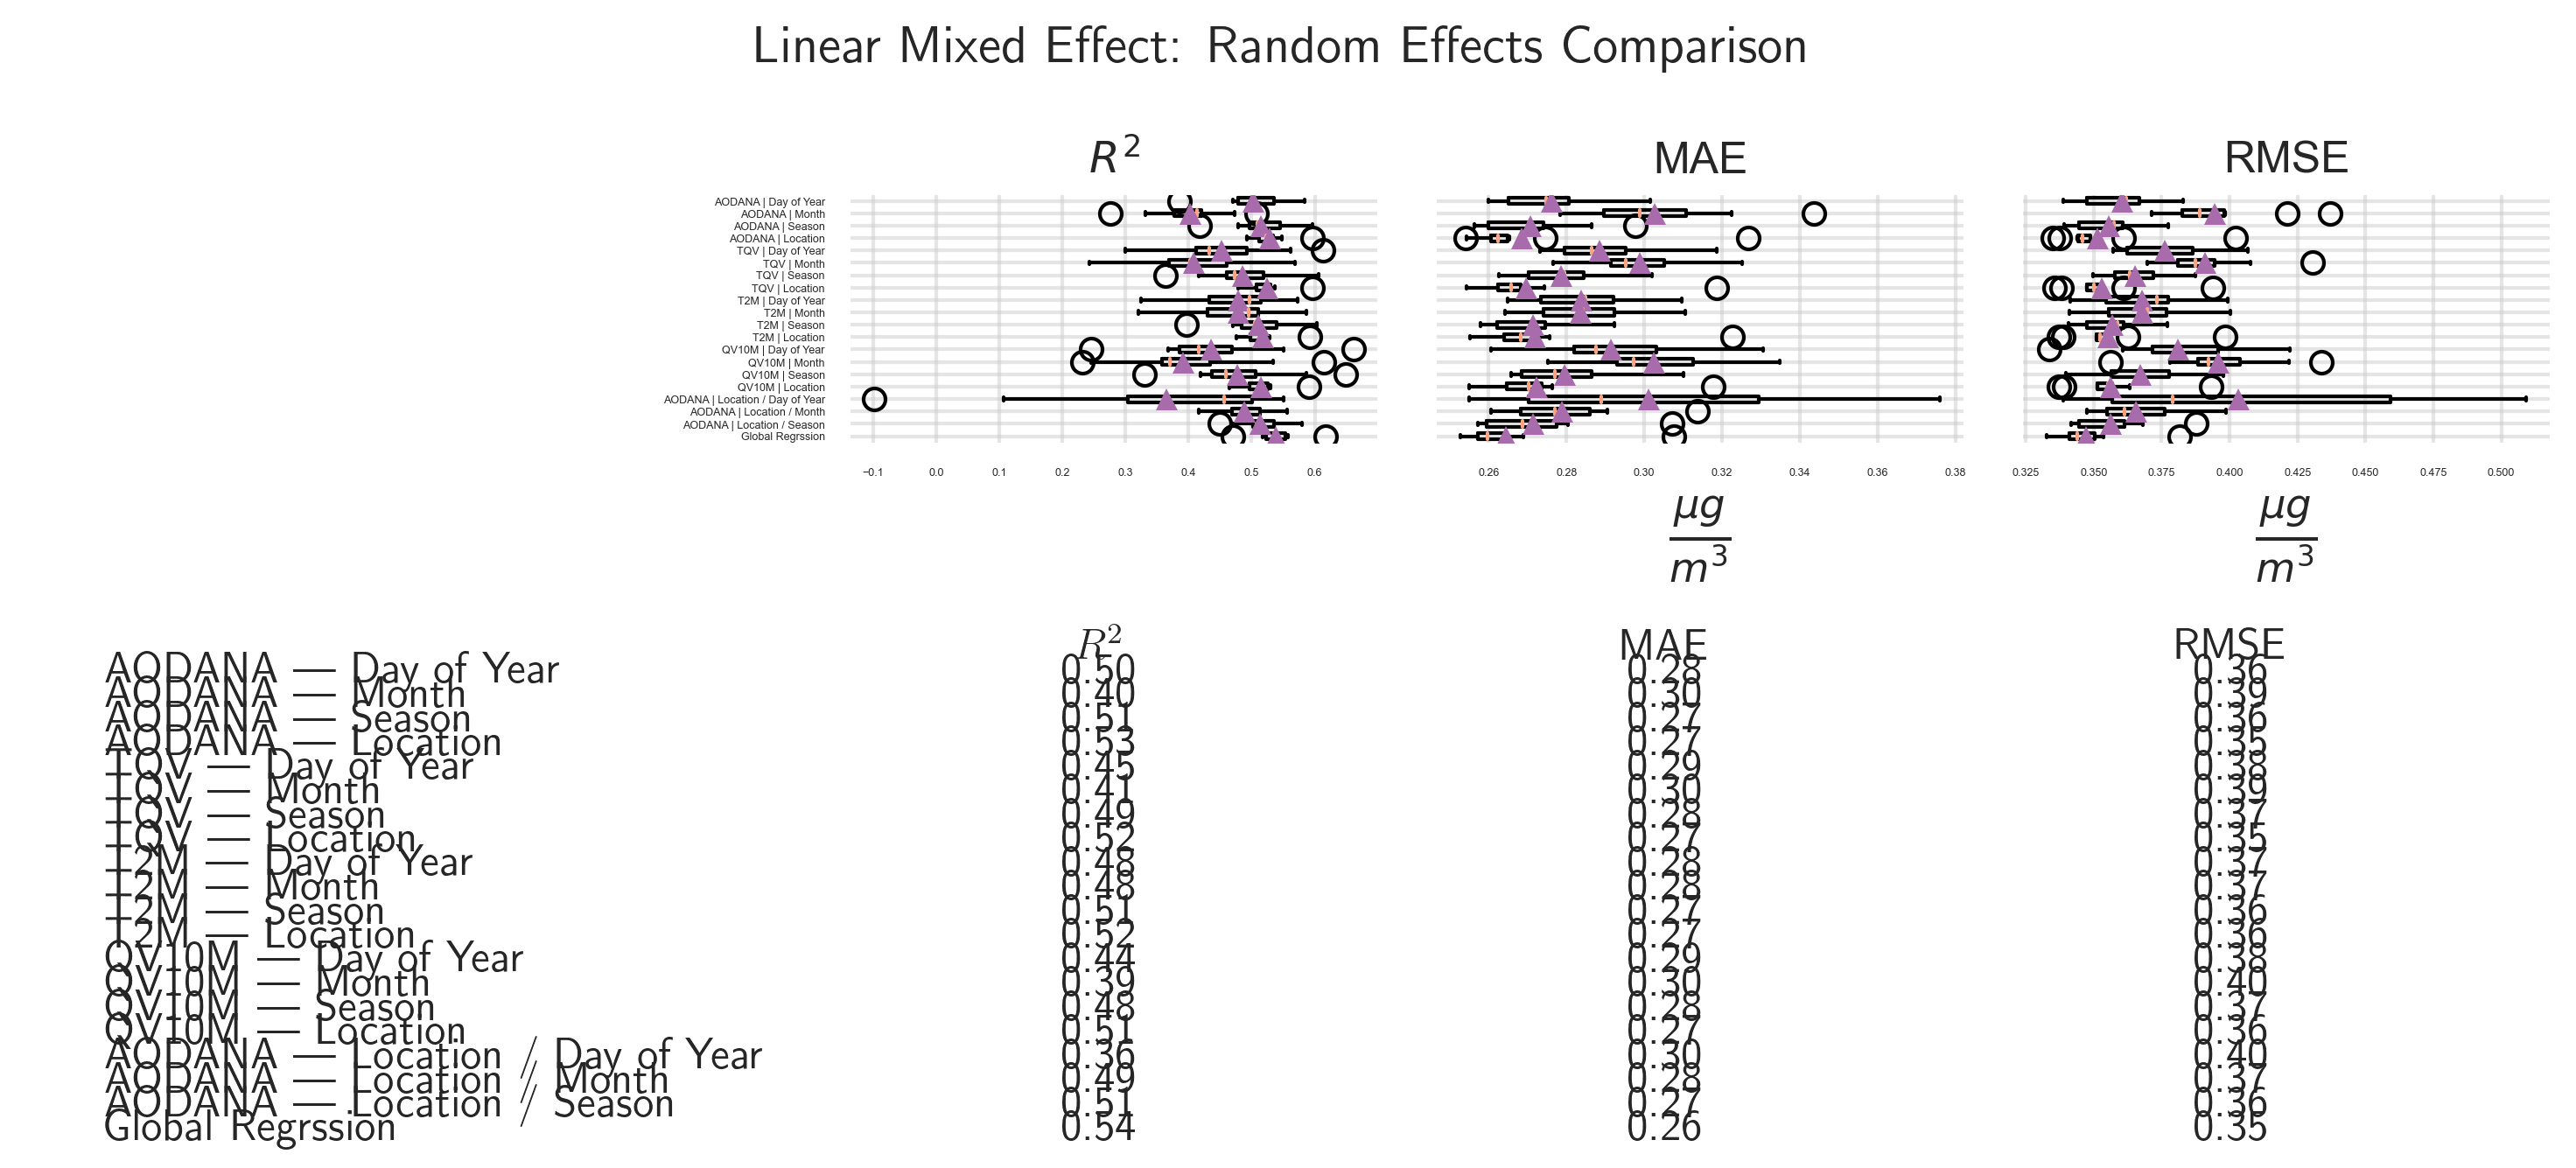

In [44]:
labels, scores = map(list, zip(*cv_scores.items()))
fig, _ = grouped_boxplot_with_table(scores, labels, fs=3, title_fontsize=12, table_fontsize=6, save=True, filename=os.path.join(paths.figures, 'lme_comparison.png'))
fig.suptitle('Linear Mixed Effect: Random Effects Comparison', y=1.05);

In [45]:
the_scores = pd.DataFrame(cv_scores)

In [46]:
print(the_scores.applymap(np.mean).T.to_csv())

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error
AODANA | Day of Year,183.50517072677613,4.886820650100708,0.5015717315796964,-0.27606660415238793,-0.36034995242412104
AODANA | Month,185.84544057846068,5.584319519996643,0.4027524154561588,-0.30267493203043294,-0.39458584677587455
AODANA | Season,168.95697810649872,5.260464358329773,0.5143619381564478,-0.2707774694706265,-0.35570267876956807
AODANA | Location,160.51517136096953,4.685312581062317,0.5278669043567623,-0.26846257486123887,-0.3515060296963969
TQV | Day of Year,165.9167861223221,4.415987658500671,0.45264694713240167,-0.28852985027266825,-0.3762641155363948
TQV | Month,173.8059618473053,5.027958369255066,0.40838280262048743,-0.29889891744953856,-0.39105206444931084
TQV | Season,171.10904026031494,5.299122762680054,0.4852556897888302,-0.2784887725947359,-0.365331351891523
TQV | Location,158.48946032524108,4.865701723098755,0.5238163477051716,-0.26951141918358884,-0.35284764423533543
T2M

## Hyper Parameter Tuning

In [47]:
from sklearn.model_selection import GridSearchCV

In [48]:
# params={
#     'base_estimator': [DecisionTreeRegressor(max_depth=3), DecisionTreeRegressor(max_depth=4), DecisionTreeRegressor(max_depth=5)],
#     'learning_rate': np.arange(0.5, 2, .1),
#     'loss': ['linear', 'square', 'exponential'],
#     'n_estimators': np.arange(10, 100, 10)
# }

# ada_grid = GridSearchCV(
#     AdaBoostRegressor(), 
#     params, 
#     cv=10, 
#     scoring=mc.scoring, 
#     refit='neg_root_mean_squared_error',
#     n_jobs=-1)

# _x = x.copy()
# ada_grid.fit(_x, y)

## Plotting

In [49]:
# model = mc.models['Linear Mixed Effect'].model_

# fig, (ax1, ax2) = plt.subplots(1, 2, dpi=300)

# model.plot("AODANA", plot_ci=True, ylabel="Predicted $\ln [PM2.5]$", ax=ax1)
# model.plot("QV2M", plot_ci=True, ylabel="Predicted $\ln [PM2.5]$", ax=ax2)

# ax1.set_ylim((-6, 6))
# ax1.set_xlim((0, 2))

# ax2.set_ylim((-6, -2.5))
# ax2.set_xlim((0, .025))

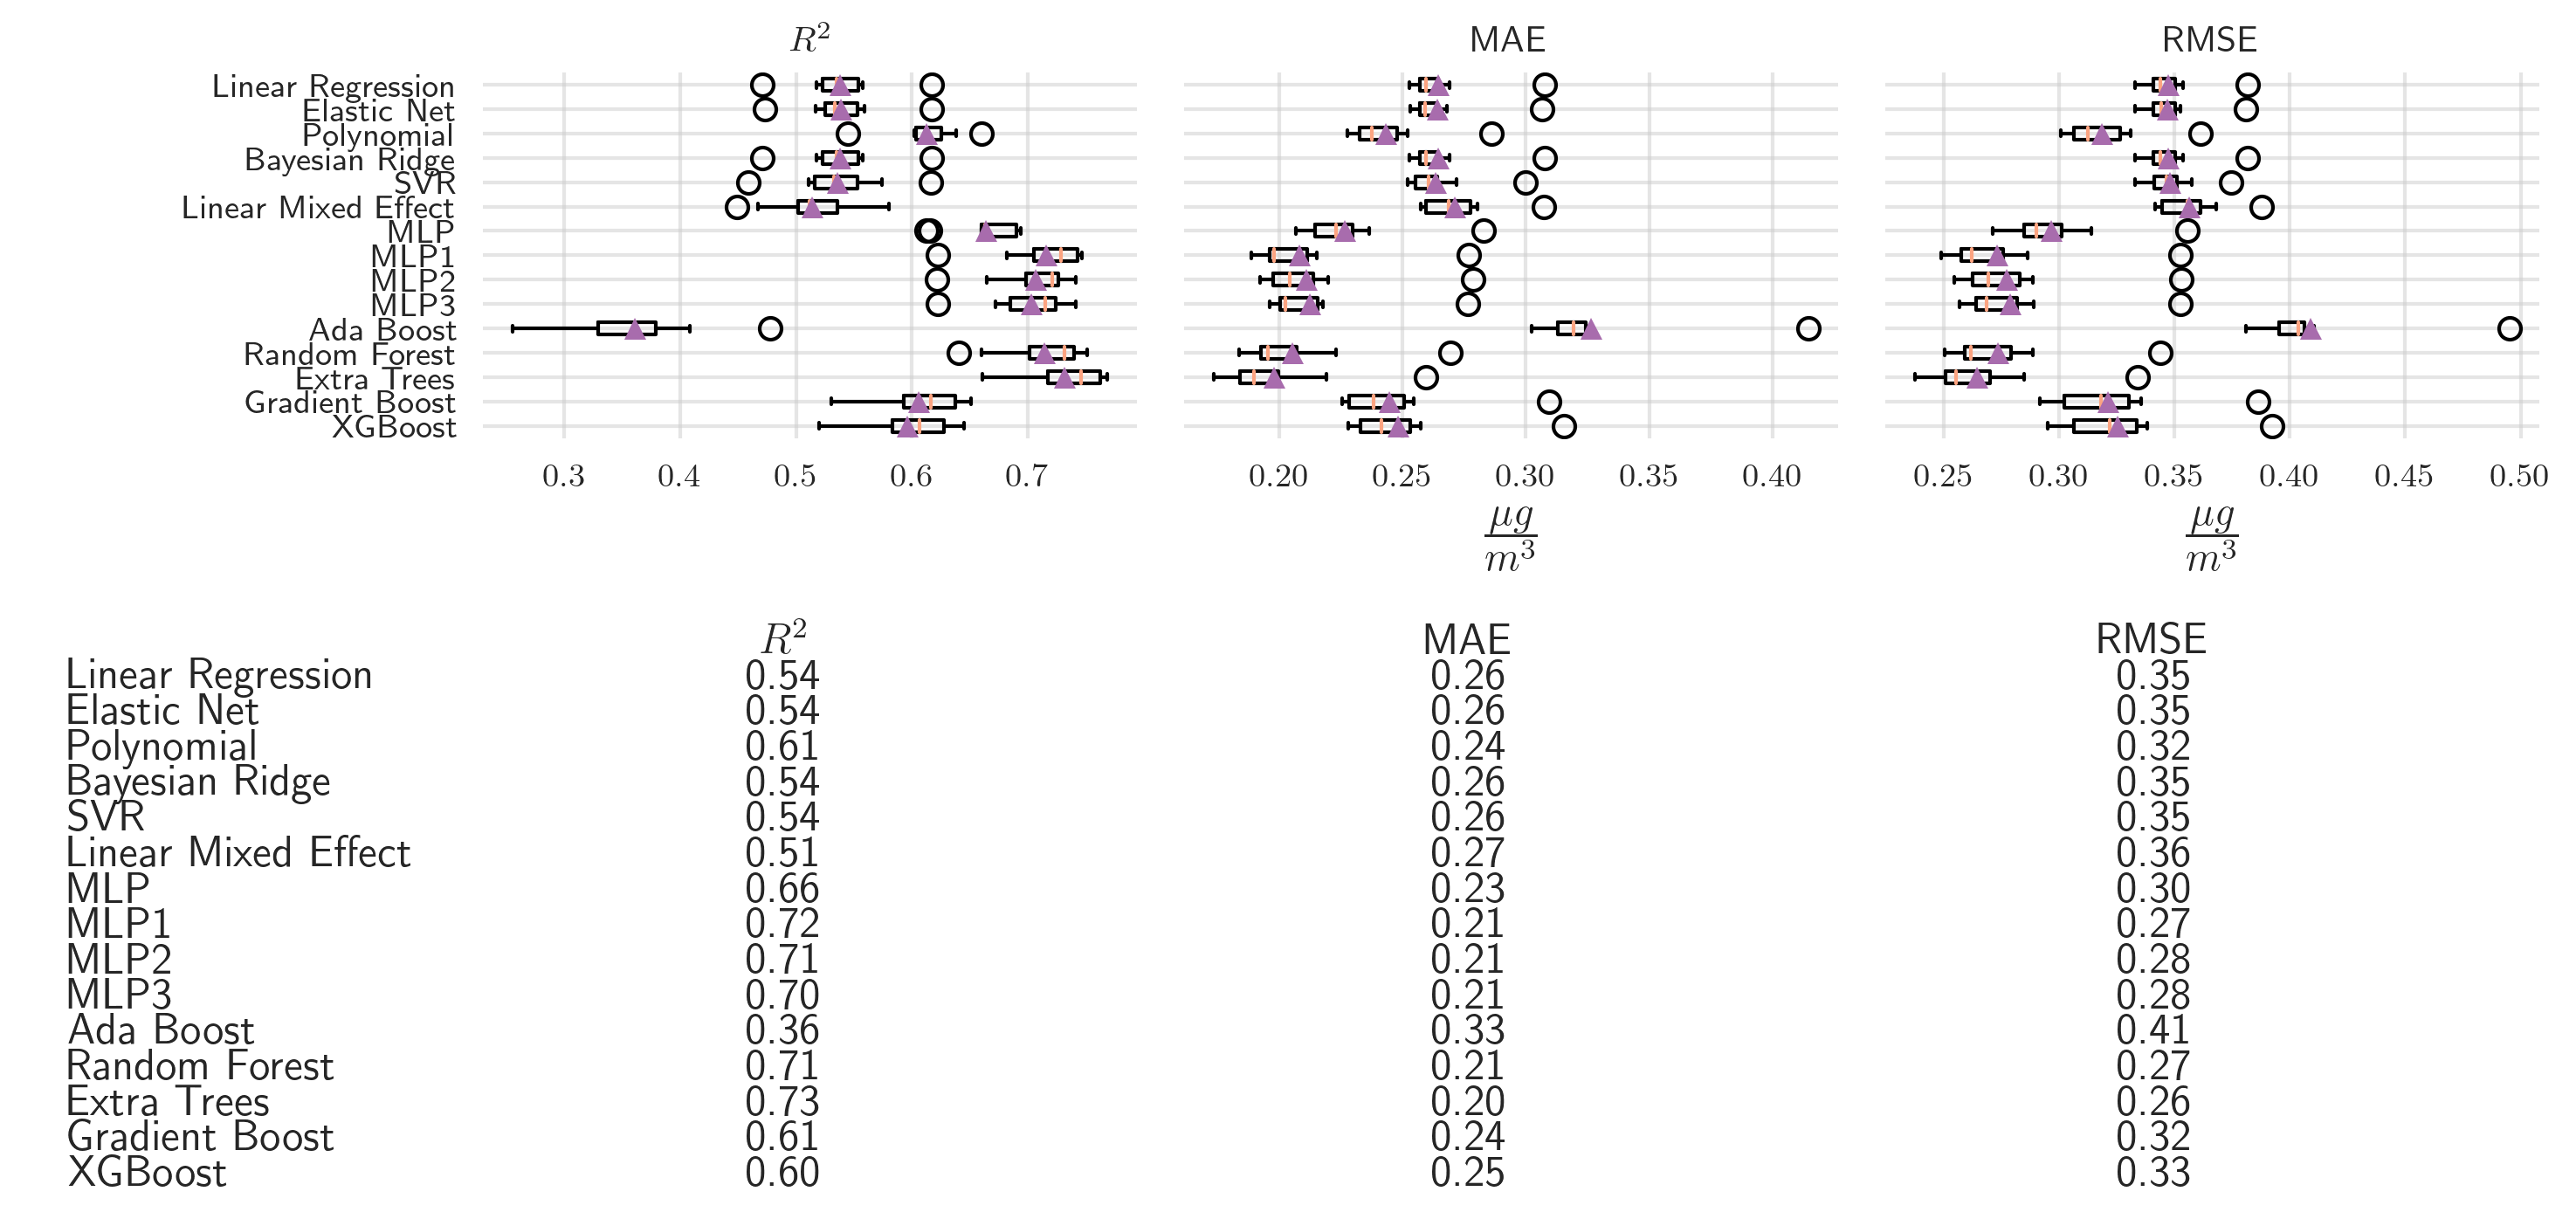

In [50]:
labels, scores = map(list, zip(*mc.cross_val_scores_.items()))
grouped_boxplot_with_table(scores, labels, save=True, filename=os.path.join(paths.figures, 'scores-2010-17.png'), fs=9);

In [51]:
# for name, model in mc.models.items():
#     residuals_plot(model, x_train.copy(), y_train, x_val.copy(), y_val)

In [52]:
# for name, model in mc.models.items():
#     plot_prediction_error(model, x_val.copy(), y_val, name=f'{name}')

## Stacking

In [53]:
stack = ModelStack(mc, x_train, y_train, n = 3)

/Users/kyle/Documents/PM25/model_collection.py:623: UserWarning: The linear mixed effect model will not be considered for model stacking. See the documentation for this class for more information
  warnings.warn('The linear mixed effect model will not be considered for model stacking. See the documentation for this class for more information')


In [54]:
stack.fit()

In [55]:
stack.compute_scores(x_val, y_val)

{'r2': 0.6712415401770644,
 'rmse': 0.32227066810370775,
 'mae': 0.2439423825873925}

In [60]:
stack.save(os.path.join(paths.models, 'stack.joblib'))

In [228]:
stack = ModelStack.__new__(ModelStack)
stack.load(os.path.join(paths.models, 'stack.joblib'))

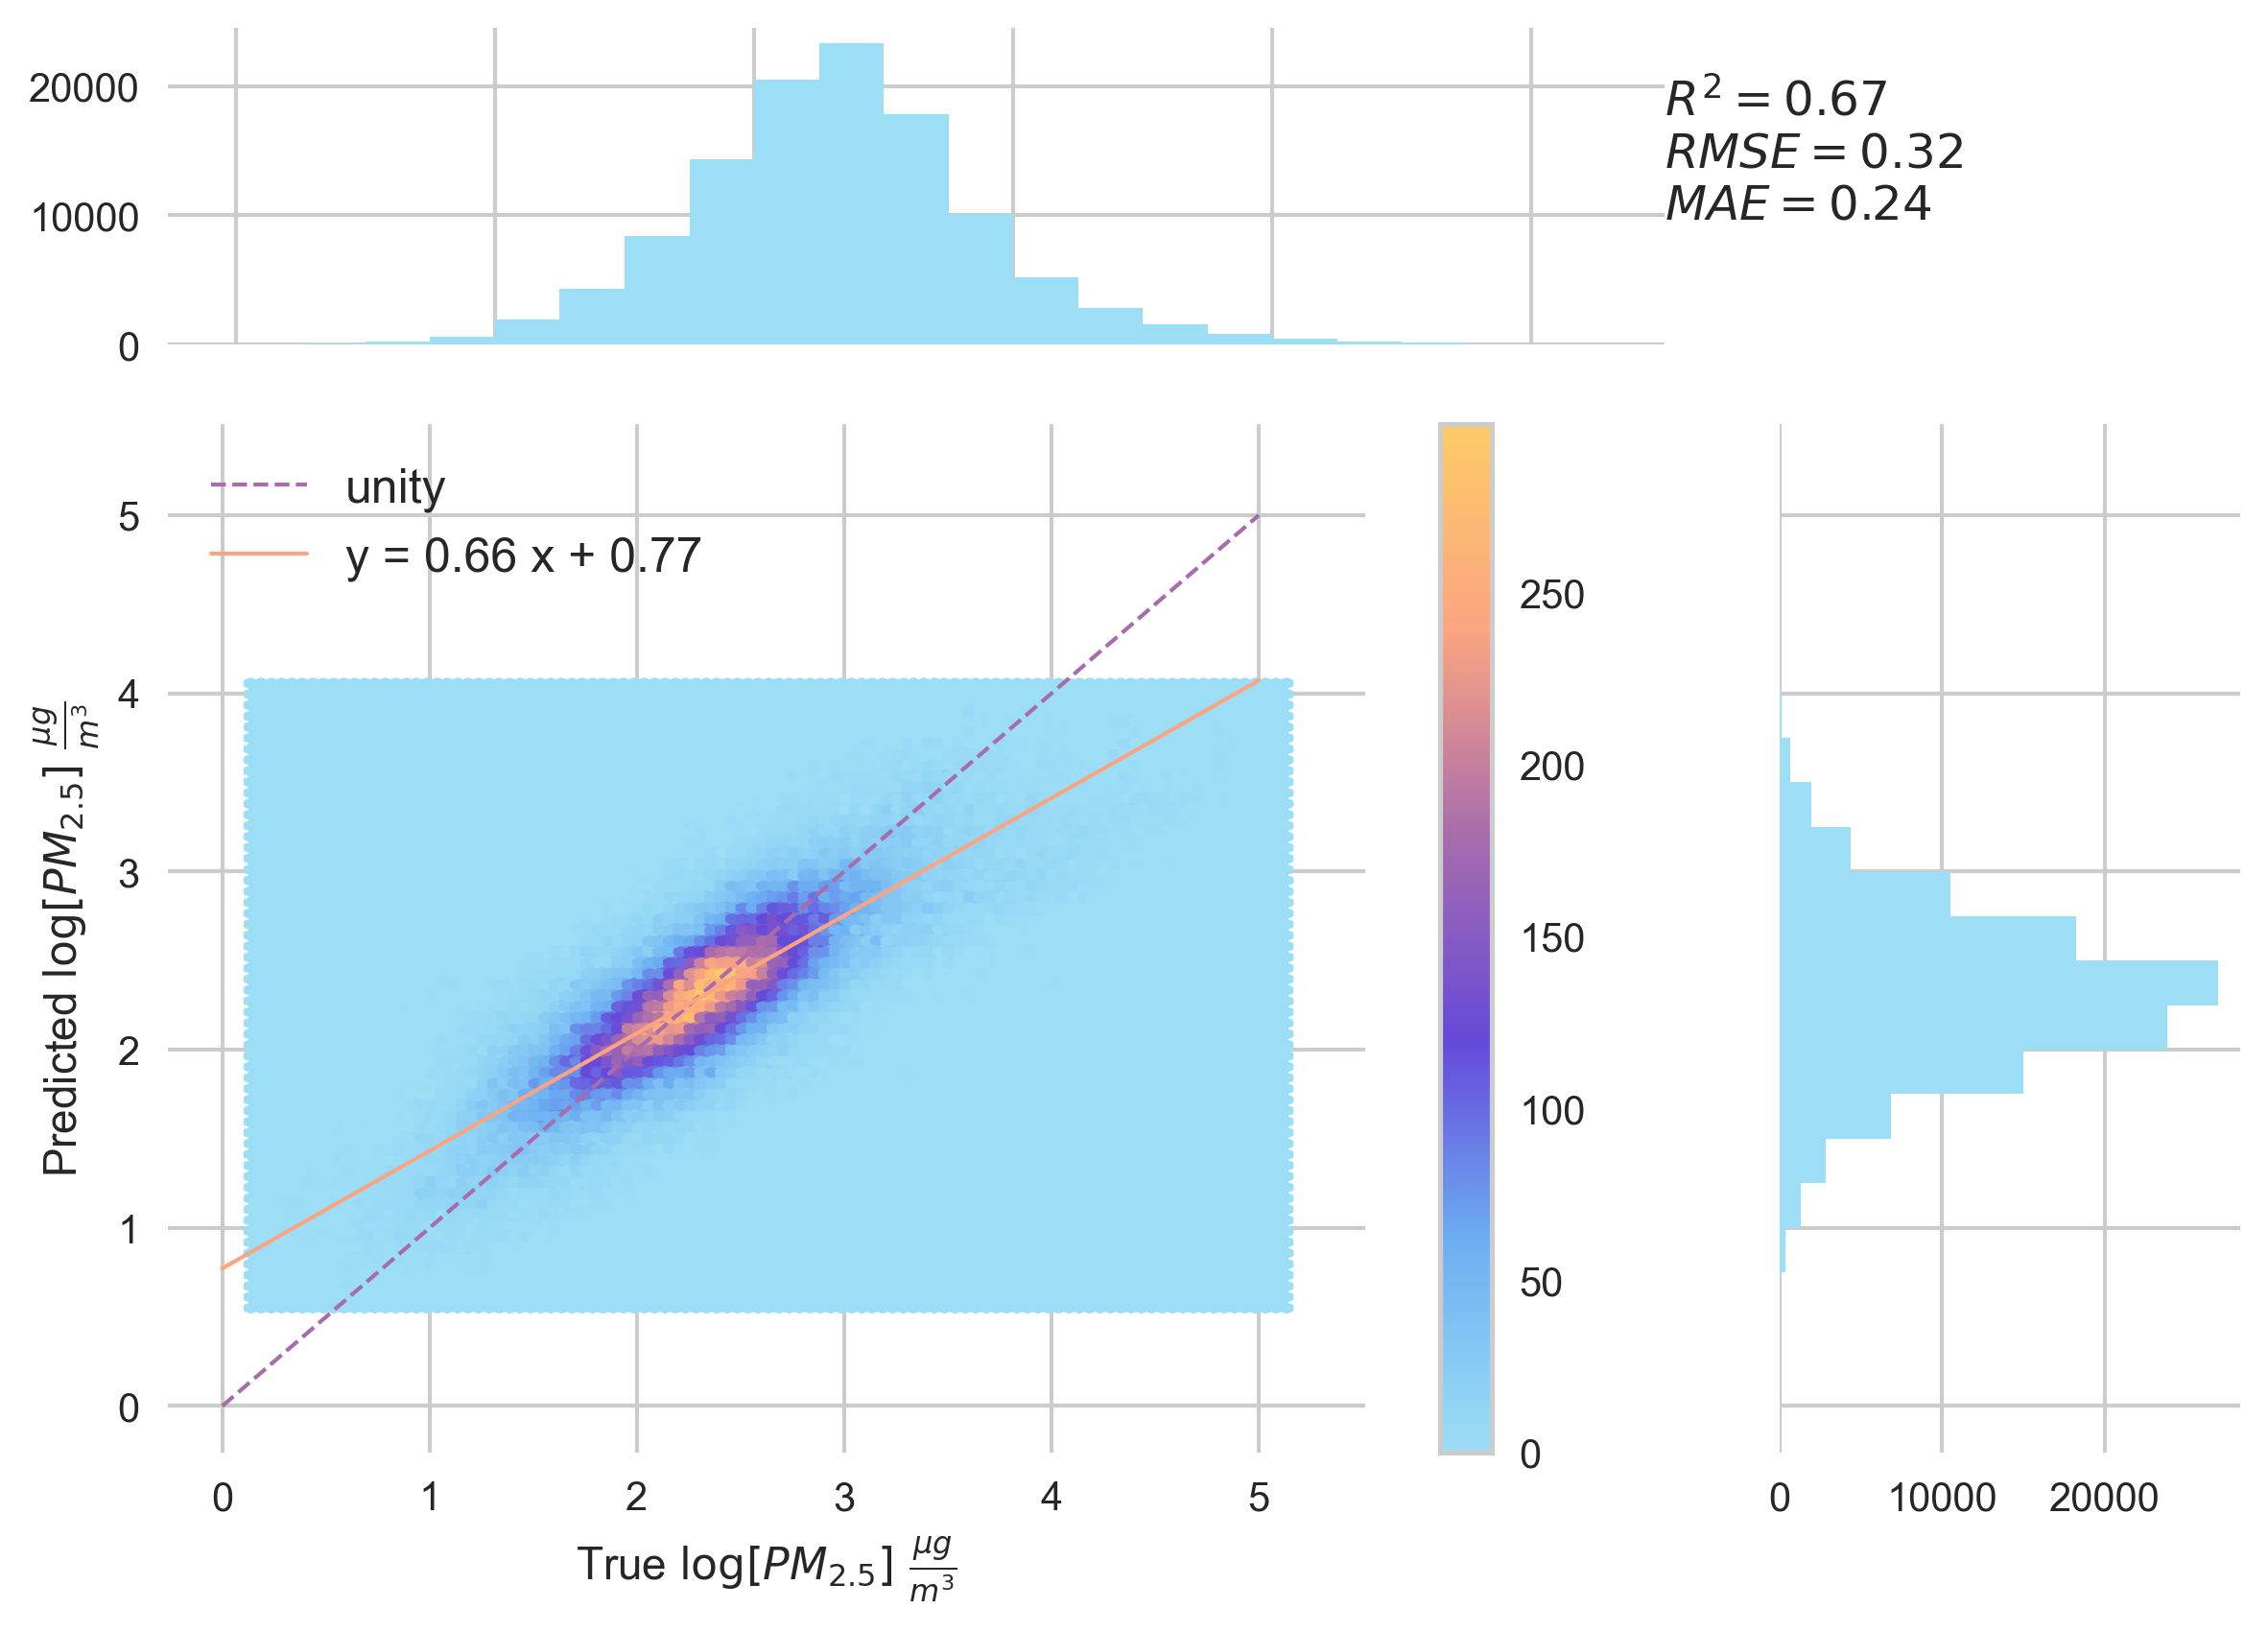

In [252]:
plot_prediction_error(stack, x_val.copy(), y_val, cmap=announce, r2_ax_locx=1.25, r2_ax_locy=1.3)

## Feature Importance

In [61]:
# columns = np.array([c.replace('_cos', ' cosine').replace('_sin', ' sine') for c in x.columns.values])
# for name, model in mc.models.items():
#     if getattr(model, 'feature_importances_', None) is not None:
#         feature_importance(mc.models[name].feature_importances_, name, columns, fontsize=18)
#         plt.savefig(f'{name}-importances-log-new-features.png')

In [62]:
# columns = np.array([c.replace('_cos', ' cosine').replace('_sin', ' sine') for c in x.columns.values])
# for name, model in mc.models.items():
#     if getattr(model, 'coef_', None) is not None:
#         feature_importance(mc.models[name].coef_, name, columns, fontsize=18)
#         plt.savefig(f'{name}-importances-log-new-features.png')

In [63]:
# columns = np.array([c.replace('_cos', ' cosine').replace('_sin', ' sine') for c in x.columns.values])
# importances = mc.models['Elastic Net'].named_steps['elastic'].coef_
# feature_importance(importances, 'Elastic Net', columns, fontsize=18)
# plt.savefig(f'Elastic Net-importances-log-new-features.png')

In [64]:
# importances = mc.models['Polynomial'].named_steps['linear'].coef_
# mask = (importances > 0.1) | (importances < -0.1)
# columns = mc.models['Polynomial'].named_steps['poly'].get_feature_names(x.columns.values)
# columns = np.array([f'${c}$'.replace(" ", " \cdot ") for c in columns])
# feature_importance(importances[mask], 'Polynomial', columns[mask], fontsize=10)
# plt.savefig(f'Polynomial-importances-log-new-features.png')

# Modeling per grid cell

In [114]:
support = features.get_support()
# select lat, lon
support[0:2] = True

x_grid = train.drop('PM2.5', axis=1).loc[:, support]
y_grid = train[['PM2.5']]

train_grid = pd.concat([x_grid, y_grid], axis=1)
train_grid_2010 = train_grid.loc['2010']
train_grid_2011 = train_grid.loc['2011']

In [123]:
mcs = {}

lme_group = 'Season'
formula = f'PM ~ QV2M + QV10M + T2M + T10M + TQV + AODANA + (1 + AODANA|{lme_group}) + ALBEDO + TS + MonthCos + DISPH'

for location, data in train_grid_2010.groupby(['lat', 'lon']):
    _x, _y = data.drop(['lat', 'lon', 'PM2.5'], axis=1), data['PM2.5']
    _mc = ModelCollection(_x.copy(), 
                          _y,
                          lme_dependent='PM', 
                          lme_formula=formula, 
                          lme_group=lme_group)
    del _mc.models['Linear Mixed Effect']
    _mc.fit()
    location = str(location)
    _mc.save(os.path.join(paths.locations, f'{location}.joblib'))
    mcs[location] = _mc

  0%|          | 0/14 [00:00<?, ?it/s]

[13:48:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:48:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:48:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01726396148271192, tolerance: 0.008038195261816494
  model = cd_fast.enet_coordinate_descent_gram(


[13:48:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:48:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:48:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:48:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:48:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:48:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:48:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:48:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:48:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0057837178716226845, tolerance: 0.0057347697562074
  model = cd_fast.enet_coordinate_descent_gram(


[13:48:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:48:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:48:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:48:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005901153245488899, tolerance: 0.0052570887187003736
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006108764671598266, tolerance: 0.0052570887187003736
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006197185425829588, tolerance: 0.0052570887187003736
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/

[13:49:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:49:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:49:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:49:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:49:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:49:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:49:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:49:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0062032262100899516, tolerance: 0.004942079167162733
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00644624746946576, tolerance: 0.004942079167162733
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009336380303377467, tolerance: 0.0052822626635785986
  model = cd_fast.enet_coordinate_descent_gram(


[13:49:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:49:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.055927060282851215, tolerance: 0.005975193788924244
  model = cd_fast.enet_coordinate_descent(


[13:49:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:49:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:49:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:50:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:50:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.015336336873264855, tolerance: 0.0075703690813022995
  model = cd_fast.enet_coordinate_descent(


[13:50:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.023017549495104817, tolerance: 0.00840644841363447
  model = cd_fast.enet_coordinate_descent(


[13:50:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:50:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:50:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:50:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04887490554014562, tolerance: 0.005819260233263103
  model = cd_fast.enet_coordinate_descent(


[13:50:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:50:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.020902791209305605, tolerance: 0.006372111767533096
  model = cd_fast.enet_coordinate_descent(


[13:50:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:50:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.024639920483863875, tolerance: 0.007622663068095334
  model = cd_fast.enet_coordinate_descent(


[13:50:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:51:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02172590341425007, tolerance: 0.007329127010882117
  model = cd_fast.enet_coordinate_descent(


[13:51:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:51:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.018669928690535187, tolerance: 0.008695086228596487
  model = cd_fast.enet_coordinate_descent(


[13:51:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:51:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:51:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:51:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:51:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:51:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:51:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:51:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:51:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05802836943362166, tolerance: 0.005950910291382434
  model = cd_fast.enet_coordinate_descent(


[13:51:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06796865828159326, tolerance: 0.006444782363705949
  model = cd_fast.enet_coordinate_descent(


[13:51:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08463915777673847, tolerance: 0.0067863773665366054
  model = cd_fast.enet_coordinate_descent(


[13:52:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.056729456844557546, tolerance: 0.007202154022040422
  model = cd_fast.enet_coordinate_descent(


[13:52:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0077271689172278, tolerance: 0.00735100601068726
  model = cd_fast.enet_coordinate_descent_gram(


[13:52:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:52:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0066825058036492635, tolerance: 0.0065594521580171075
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0067961412610735294, tolerance: 0.0065594521580171075
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006711043526230753, tolerance: 0.0065594521580171075
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Document

[13:52:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008762043584798818, tolerance: 0.00731993410098467
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008885599894622231, tolerance: 0.00731993410098467
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008762692899381364, tolerance: 0.00731993410098467
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/p

[13:52:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009936204439945584, tolerance: 0.008605214170540368
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009886472608528152, tolerance: 0.008605214170540368
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009658834429799867, tolerance: 0.008605214170540368
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM2

[13:52:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:52:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:52:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:52:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:52:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:52:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:53:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:53:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:53:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:53:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:53:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03992735857553242, tolerance: 0.006393267539341953
  model = cd_fast.enet_coordinate_descent(


[13:53:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0963593596983614, tolerance: 0.0068577687236111365
  model = cd_fast.enet_coordinate_descent(


[13:53:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:53:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009038371055154926, tolerance: 0.007225715006804859
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009258496047337417, tolerance: 0.007225715006804859
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009270343710760187, tolerance: 0.007225715006804859
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM2

[13:53:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007596251993113867, tolerance: 0.007439626376809449
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012622787581953787, tolerance: 0.008068508768445089
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012499977996462519, tolerance: 0.008068508768445089
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM2

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.015947943540489007, tolerance: 0.008448997799921807
  model = cd_fast.enet_coordinate_descent(


[13:53:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:53:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01189037174562202, tolerance: 0.010005723475594112
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011711678140279957, tolerance: 0.010005723475594112
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01133977418727028, tolerance: 0.010005723475594112
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/

[13:54:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01086406818600949, tolerance: 0.009542186289597682
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010208006395224345, tolerance: 0.009542186289597682
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.16158593106533203, tolerance: 0.011280918527584248
  model = cd_fast.enet_coordinate_descent(


[13:54:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:54:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:54:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:54:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005486349403174273, tolerance: 0.004732619325557005
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005860897925490605, tolerance: 0.004732619325557005
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005086242883361791, tolerance: 0.004583384953279139
  model = cd_fast.enet_coordinate_descent_gram(


[13:54:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005610314428452057, tolerance: 0.00482819312639825
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005619846402463935, tolerance: 0.00482819312639825
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005481561529258272, tolerance: 0.00482819312639825
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/p

[13:54:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006542731173237115, tolerance: 0.0055192340712876525
  model = cd_fast.enet_coordinate_descent_gram(


[13:54:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005935572066910311, tolerance: 0.005220210149938682
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005751916264316037, tolerance: 0.005390567337798101
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005848842005072186, tolerance: 0.005390567337798101
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM2

[13:54:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:54:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:54:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0070015952872815035, tolerance: 0.005067440526426438
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007102103464205811, tolerance: 0.005067440526426438
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0071174274812833005, tolerance: 0.005067440526426438
  model = cd_fast.enet_coordinate_descent_gram(


[13:54:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:54:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:55:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1344035875126508, tolerance: 0.006518613867154475
  model = cd_fast.enet_coordinate_descent(


[13:55:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:55:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007766218572122341, tolerance: 0.007177234173889617
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007869532161919324, tolerance: 0.007177234173889617
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007871735710146766, tolerance: 0.007177234173889617
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM2

[13:55:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009089472088710693, tolerance: 0.008110268090491281
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012177398179240129, tolerance: 0.008110268090491281
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01367479626131285, tolerance: 0.008110268090491281
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00982970969522512, tolerance: 0.0074368496370350486
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010071865137319946, tolerance: 0.0074368496370350486
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010047952062528509, tolerance: 0.0074368496370350486
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/P

[13:55:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011062220284706825, tolerance: 0.009173652703559776
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011319376392656011, tolerance: 0.009173652703559776
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009745064280458848, tolerance: 0.009173652703559776
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM2

[13:55:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01218713141815897, tolerance: 0.010167904007036679
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01650640823489624, tolerance: 0.010167904007036679
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016984683336694673, tolerance: 0.010167904007036679
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/

[13:55:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011859437916200477, tolerance: 0.010788129441522668
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011739233235118718, tolerance: 0.010788129441522668
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011496017551564819, tolerance: 0.010788129441522668
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM2

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013697859122345335, tolerance: 0.011784702607128899
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013473062975506878, tolerance: 0.011784702607128899
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013070163052304906, tolerance: 0.011784702607128899
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM2

[13:55:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:55:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:55:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01714496998959092, tolerance: 0.005239026523052261
  model = cd_fast.enet_coordinate_descent(


[13:55:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04618886321344107, tolerance: 0.00502269523580531
  model = cd_fast.enet_coordinate_descent(


[13:56:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04771040410876992, tolerance: 0.005249487596680164
  model = cd_fast.enet_coordinate_descent(


[13:56:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07114754029865722, tolerance: 0.005557820784922568
  model = cd_fast.enet_coordinate_descent(


[13:56:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006089805343446386, tolerance: 0.005286688513649417
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005662814306568009, tolerance: 0.00531716214223906
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00612532503307861, tolerance: 0.00531716214223906
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/p

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.34842143755779986, tolerance: 0.00603709134964059
  model = cd_fast.enet_coordinate_descent(


[13:56:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006730377817106614, tolerance: 0.005025904687024401
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005206496789572412, tolerance: 0.005091098137864351
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005313797832368294, tolerance: 0.005091098137864351
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM2

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5304287914978509, tolerance: 0.005863364642332474
  model = cd_fast.enet_coordinate_descent(


[13:56:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:56:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005229722247428015, tolerance: 0.004875075526147377
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005409807883669515, tolerance: 0.004875075526147377
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0055217202639212815, tolerance: 0.004875075526147377
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM

[13:56:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:56:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:56:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:56:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.030936819919553216, tolerance: 0.006347314147745285
  model = cd_fast.enet_coordinate_descent(


[13:56:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:57:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007549126692907748, tolerance: 0.007343177410237883
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007681208783154148, tolerance: 0.007343177410237883
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010349183614302149, tolerance: 0.007343177410237883
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM2

[13:57:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008575914576908872, tolerance: 0.008144928592353268
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00948093765083513, tolerance: 0.008144928592353268
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010405493573884428, tolerance: 0.008144928592353268
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010818217961045207, tolerance: 0.007776147079060428
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011246208391888501, tolerance: 0.007776147079060428
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011360278102920063, tolerance: 0.007776147079060428
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM2

[13:57:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008912067934637946, tolerance: 0.008877265952040119
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.014026402962102225, tolerance: 0.008877265952040119
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.014429913457476573, tolerance: 0.008877265952040119
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM2

[13:57:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010145308382362828, tolerance: 0.010010033563258018
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011254740291931853, tolerance: 0.010010033563258018
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016121504292677002, tolerance: 0.010010033563258018
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM2

[13:57:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.015509453001499196, tolerance: 0.011919523808414902
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.019140848147230827, tolerance: 0.011919523808414902
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.019931187791499383, tolerance: 0.011919523808414902
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM2

[13:57:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:57:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:57:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:57:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011499366109841702, tolerance: 0.006451367818988432
  model = cd_fast.enet_coordinate_descent(


[13:57:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00969325370930818, tolerance: 0.006331524543675675
  model = cd_fast.enet_coordinate_descent(


[13:57:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:57:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:58:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005865285482265392, tolerance: 0.005773065463787696
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0061204465084330195, tolerance: 0.005773065463787696
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006285136664715196, tolerance: 0.005940331123284464
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM

[13:58:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007941419607917055, tolerance: 0.005240912577860033
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00590839838964996, tolerance: 0.005326674050582533
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006375555418017598, tolerance: 0.005326674050582533
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005447321497872082, tolerance: 0.005421962720555218
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0055007068747201515, tolerance: 0.005421962720555218
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005505223918639501, tolerance: 0.005421962720555218
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM

[13:58:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005570640804581473, tolerance: 0.005245908160673422
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.049845103213542075, tolerance: 0.005631886366156586
  model = cd_fast.enet_coordinate_descent(


[13:58:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006279606126177839, tolerance: 0.005201873606065792
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005225592926901612, tolerance: 0.005016430424303221
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00561827738449594, tolerance: 0.005016430424303221
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25

[13:58:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005565256289294496, tolerance: 0.005286416413894226
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0057386137467041465, tolerance: 0.005286416413894226
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005846859579005326, tolerance: 0.005286416413894226
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM

[13:58:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:58:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:58:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006716826547048527, tolerance: 0.006159656714797865
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006645481491283078, tolerance: 0.006159656714797865
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006504487143601523, tolerance: 0.006159656714797865
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM2

[13:58:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.20842944020434473, tolerance: 0.0068588829073802406
  model = cd_fast.enet_coordinate_descent(


[13:58:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007145567622103499, tolerance: 0.006514233279643029
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007932102636399208, tolerance: 0.006554226333080977
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.015442076378896274, tolerance: 0.007314992904614687
  model = cd_fast.enet_coordinate_descent_gram(


[13:59:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011056360985712388, tolerance: 0.008217286386834284
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011739716723475624, tolerance: 0.008217286386834284
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012090465194503963, tolerance: 0.008217286386834284
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM2

[13:59:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008947629358722509, tolerance: 0.008614160491558245
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009951829902483667, tolerance: 0.008614160491558245
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011001611715862225, tolerance: 0.008614160491558245
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM2

[13:59:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010193502689133993, tolerance: 0.009968299566396579
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012434957882447861, tolerance: 0.009968299566396579
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012523660201679832, tolerance: 0.009968299566396579
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM2

[13:59:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:59:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0071997760873863115, tolerance: 0.007121661299849264
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0072373925951225715, tolerance: 0.007121661299849264
  model = cd_fast.enet_coordinate_descent_gram(


[13:59:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006724277350404151, tolerance: 0.005927976158490512
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006074853522473944, tolerance: 0.0059281010503784625
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006342429577884445, tolerance: 0.0059281010503784625
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/P

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0071420375560506955, tolerance: 0.005963883635224722
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007263864518321839, tolerance: 0.005963883635224722
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007306927987393408, tolerance: 0.005963883635224722
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM

[13:59:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0063443172839754425, tolerance: 0.00527597511480843
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006414403792906143, tolerance: 0.0053905043508186016
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0068051469791825525, tolerance: 0.005421673810839912
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/P

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0060069712759514005, tolerance: 0.005614926814645582
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006000034115874797, tolerance: 0.005614926814645582
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005963126955037978, tolerance: 0.005614926814645582
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM

[13:59:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006019187328902831, tolerance: 0.005313353662490148
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006859276304645334, tolerance: 0.005507918937292674
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00557056046393356, tolerance: 0.005476043115595099
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006051208630239557, tolerance: 0.005694749219979199
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0059887653968857535, tolerance: 0.005694749219979199
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005894715844078746, tolerance: 0.005694749219979199
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM

[13:59:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[13:59:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[14:00:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[14:00:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.057472407045981555, tolerance: 0.0067443857175496875
  model = cd_fast.enet_coordinate_descent(


[14:00:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.15701658792549011, tolerance: 0.007047751022005929
  model = cd_fast.enet_coordinate_descent(


[14:00:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[14:00:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01063016986324783, tolerance: 0.008579997955138053
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007822331969670415, tolerance: 0.007789681143480599
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008109087016130445, tolerance: 0.007789681143480599
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013340060033279144, tolerance: 0.00808798810430039
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.014282920264292898, tolerance: 0.00808798810430039
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007724841554100692, tolerance: 0.007413395104548366
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/

[14:00:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009962303397074379, tolerance: 0.009633412337452369
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012986276731702162, tolerance: 0.009633412337452369
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.014558587790794775, tolerance: 0.009633412337452369
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM2

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012903352398836887, tolerance: 0.009454583327729584
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012820485357480038, tolerance: 0.009454583327729584
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012688382369780982, tolerance: 0.009454583327729584
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM2

[14:00:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012422799122703054, tolerance: 0.011832876238907077
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012268208779090628, tolerance: 0.011832876238907077
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012017742151556376, tolerance: 0.011832876238907077
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM2

[14:00:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[14:00:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[14:00:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0076965466758878165, tolerance: 0.00737067658143229
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008062998073331329, tolerance: 0.007528774694451073
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008323776913698566, tolerance: 0.007528774694451073
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM2

[14:01:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006444579923886806, tolerance: 0.006270061335615926
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007001616328331295, tolerance: 0.006379787706563678
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007395532802703997, tolerance: 0.006379787706563678
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM2

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008884930123734591, tolerance: 0.006947142960585666
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007255024008060218, tolerance: 0.00680325818079524
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007599039325555168, tolerance: 0.00680325818079524
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/

[14:01:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006035508156198688, tolerance: 0.005764586256877484
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008494880783985082, tolerance: 0.005764586256877484
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008939376230852503, tolerance: 0.005764586256877484
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM2

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007456781078289509, tolerance: 0.006095559887867476
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007590524582482772, tolerance: 0.006095559887867476
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0074276449513313025, tolerance: 0.006095559887867476
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM

[14:01:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006518203628761654, tolerance: 0.005890762465802838
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005943795682675557, tolerance: 0.005874028229319686
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0063776489230384925, tolerance: 0.005874028229319686
  model = cd_fast.enet_coordinate_descent_gram(


[14:01:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[14:01:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011213600098720633, tolerance: 0.006445229888146498
  model = cd_fast.enet_coordinate_descent_gram(


[14:01:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[14:01:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0076527904917824685, tolerance: 0.006707165558492337
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007670950957447076, tolerance: 0.006707165558492337
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007531679342910991, tolerance: 0.006707165558492337
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23542755350277034, tolerance: 0.007474601612041126
  model = cd_fast.enet_coordinate_descent(


[14:01:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009193276999539535, tolerance: 0.00781608147641875
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009407604833846506, tolerance: 0.00781608147641875
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009425786130790925, tolerance: 0.00781608147641875
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/p

[14:02:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011726553704740184, tolerance: 0.00876424704223544
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.014067911974571246, tolerance: 0.00876424704223544
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011680718321557038, tolerance: 0.00799337866729679
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/p

[14:02:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012128592084138745, tolerance: 0.009138094861256113
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.017550084536445354, tolerance: 0.009138094861256113
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016871076983939304, tolerance: 0.009307549536093836
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM2

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05836743905522468, tolerance: 0.009138094861256113
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.018241596662058157, tolerance: 0.009216220633545167
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.019769892789227583, tolerance: 0.009216220633545167
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25

[14:02:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.020106848493639973, tolerance: 0.012014819551607917
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.020330669414960312, tolerance: 0.012014819551607917
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.019969395045812632, tolerance: 0.012014819551607917
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM2

[14:02:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[14:02:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[14:02:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[14:02:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010678718589673508, tolerance: 0.008592900228304598
  model = cd_fast.enet_coordinate_descent(


[14:02:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01046806734107264, tolerance: 0.006413728751133654
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011790722174339408, tolerance: 0.006413728751133654
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012030182544336299, tolerance: 0.006413728751133654
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25

[14:02:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[14:02:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[14:02:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[14:03:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013743598582315997, tolerance: 0.006970046111822598
  model = cd_fast.enet_coordinate_descent_gram(


[14:03:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008079381285856613, tolerance: 0.007687047776891248
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008027346659929435, tolerance: 0.007687047776891248
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007903571544169097, tolerance: 0.007687047776891248
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM2

[14:03:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010973661585310879, tolerance: 0.008330732421920811
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01452583701222565, tolerance: 0.008330732421920811
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.015289680060096345, tolerance: 0.008330732421920811
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25

[14:03:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009312747911927488, tolerance: 0.00798483946954334
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009649267151317531, tolerance: 0.00814376239395955
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013149633471854827, tolerance: 0.008708396352998131
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/

[14:03:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00921685034730757, tolerance: 0.009072138123989694
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010321833539450154, tolerance: 0.009072138123989694
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009805418221993989, tolerance: 0.00979041856283188
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.030469433047286998, tolerance: 0.009072138123989694
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.014246243416060622, tolerance: 0.00979041856283188
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.024232206992891747, tolerance: 0.00979041856283188
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/

[14:03:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01205138859462096, tolerance: 0.01139540457578558
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.019191689795277966, tolerance: 0.01139540457578558
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.021667272718097763, tolerance: 0.01139540457578558
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.014598434138363814, tolerance: 0.011296689996497973
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.022266980991197727, tolerance: 0.011296689996497973
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02306847245814936, tolerance: 0.011296689996497973
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6180014555795594, tolerance: 0.01179113175878902
  model = cd_fast.enet_coordinate_descent(


[14:03:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[14:03:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[14:03:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[14:03:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[14:03:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[14:04:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[14:04:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[14:04:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[14:04:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[14:04:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[14:04:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[14:04:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[14:04:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[14:04:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[14:04:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[14:04:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[14:04:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[14:05:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[14:05:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[14:05:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[14:05:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[14:05:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[14:05:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[14:05:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[14:05:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[14:05:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/14 [00:00<?, ?it/s]

[14:05:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [140]:
import glob

mcs = {}

for file in glob.glob(os.path.join(paths.locations, '*')):
    _file_name = os.path.basename(file)
    _location = os.path.splitext(_file_name)[0]
    _mc = ModelCollection.__new__(ModelCollection)
    _mc.load(file)
    mcs[_location] = _mc

[15:26:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:26:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:26:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:26:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:26:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:26:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:26:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:26:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:26:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[15:26:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:26:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:26:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:26:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:26:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:26:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:26:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:26:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:26:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[15:27:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:27:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:27:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:27:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:27:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:27:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:27:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:27:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:27:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

In [143]:
mcs[_location].scaler.mean_

array([ 8.77907814e-03,  8.57824184e-03,  2.90787170e+02,  2.90877083e+02,
        2.24476397e+01, -2.14529047e+00,  1.82171736e-01,  2.91299096e+02,
       -2.37267234e-03,  2.39632788e-01])

In [184]:
grid_predictions = None
grid_scores = None

for location, data in train_grid_2011.groupby(['lat', 'lon']):
    _mc = mcs[str(location)]
    
    _x = data.copy()
    _x = _x.drop(['lat', 'lon', 'PM2.5'], axis=1)
    
    _predictions = _mc.predict(_x)
    _predictions = pd.DataFrame(_predictions, index=data.index)
    _predictions['True Value'] = data['PM2.5']
    
    _scores = scores_from_model_collection_predictions(_predictions).T
    _scores['lat'] = pd.Series([location[0] for i in range(len(_scores.index))], index=_scores.index)
    _scores['lon'] = pd.Series([location[1] for i in range(len(_scores.index))], index=_scores.index)
    
    _predictions['lat'] = pd.Series([location[0] for i in range(len(data.index))], index=data.index)
    _predictions['lon'] = pd.Series([location[1] for i in range(len(data.index))], index=data.index)
    
    if grid_predictions is None:
        grid_predictions = _predictions
        
    else:
        grid_predictions = pd.concat([grid_predictions, _predictions])

In [203]:
grid_predictions = grid_predictions.reset_index().set_index(['time', 'lat', 'lon']).to_xarray()
grid_predictions_file = os.path.join(paths.locations, '2011_predictions.nc4')
grid_predictions.to_netcdf(grid_predictions_file)

In [206]:
difference_from_true(grid_predictions)

ValueError: cannot convert a DataFrame with a non-unique MultiIndex into xarray

# Publication Figures

In [75]:
idx = np.argsort(features.scores_)[::-1]
mi_scores = pd.DataFrame({'Features': train.drop('PM2.5', axis=1).columns.values[idx], 'Scores': features.scores_[idx]})
print(mi_scores.to_csv(index=False))

Features,Scores
AODANA,0.40697518743608985
QV10M,0.182702600779737
T2M,0.18255480358238962
TS,0.18127295057994264
QV2M,0.1808070429405566
T10M,0.17937127088957006
TQV,0.16578539252998947
MonthCos,0.1398947169664666
ALBEDO,0.08846724165801945
DISPH,0.07616948558023662
EMIS,0.07500319584993154
TPRECMAX,0.06874225310426763
PS,0.06413503314018598
lon,0.058084248188796206
lat,0.054496824110723985
V2M,0.05205015286239778
V50M,0.04925578394325214
V10M,0.04856902506593386
TQI,0.044236322878314915
U50M,0.04005825321871992
U2M,0.03835071732511697
U10M,0.038284773998680244
TQL,0.03165430146987891
MonthSin,0.030867369407716616
CLDTOT,0.01637398969695525



In [76]:
# labels, scores = map(list, zip(*mc.cross_val_scores_.items()))
models = []
r2s = []
maes = []
rmses = []

for model_name, score in mc.cross_val_scores_.items():
    r2, mae, rmse = summarize_scores(score)
    models.append(model_name)
    r2s.append(r2)
    maes.append(mae)
    rmses.append(rmse)

print(pd.DataFrame({'Model': models, 'R2': r2s, 'MAE': maes, 'RMSE': rmses}).to_csv(index=False))

Model,R2,MAE,RMSE
Linear Regression,0.5381725253067811,0.2643613652875307,0.34722288392627854
Elastic Net,0.5385439737404779,0.26402373508170396,0.34709000299920156
Polynomial,0.6125105917739742,0.2432087193237662,0.318363097516604
Bayesian Ridge,0.5381805432041838,0.26435695436803036,0.3472197288873389
SVR,0.5358498691194158,0.26353476145591676,0.34791755681941483
Linear Mixed Effect,0.5136626520316411,0.27136104211021833,0.3563717754651649
MLP,0.6642080306480305,0.2267425404878058,0.2966613448461653
MLP1,0.7156447472737167,0.20819932961986348,0.2729593441461023
MLP2,0.7066961868132351,0.21108520914358406,0.2772485929163925
MLP3,0.7034117972577316,0.2124210365383925,0.278731085933228
Ada Boost,0.3607512899600125,0.32626540665217957,0.40904043890500785
Random Forest,0.7145443111842221,0.20525868998847185,0.2733291789637721
Extra Trees,0.7321483990792748,0.1979453145080309,0.2646052044771723
Gradient Boost,0.6062036269550781,0.24480654812233457,0.32112383719875864
XGBoost,0.596074187109

In [ ]:
# fig, (ax1, ax2) = plt.subplots(1, 2, dpi=300)

# pm = y_train
# aod = x_train['AODANA'].apply(np.exp)
# log_aod = x_train['AODANA']

# ax1.hexbin(x=aod, y=pm)
# ax2.hexbin(x=log_aod, y=pm)

# ax1.set_ylabel('$\log PM_{2.5}$')
# ax2.set_ylabel('')

# ax1.set_xlabel('$AOD$')
# ax2.set_xlabel('$\log AOD$')

# ax.grid(False)

# plt.savefig(os.path.join(paths.figures, 'pm-aod-relationship.png'))

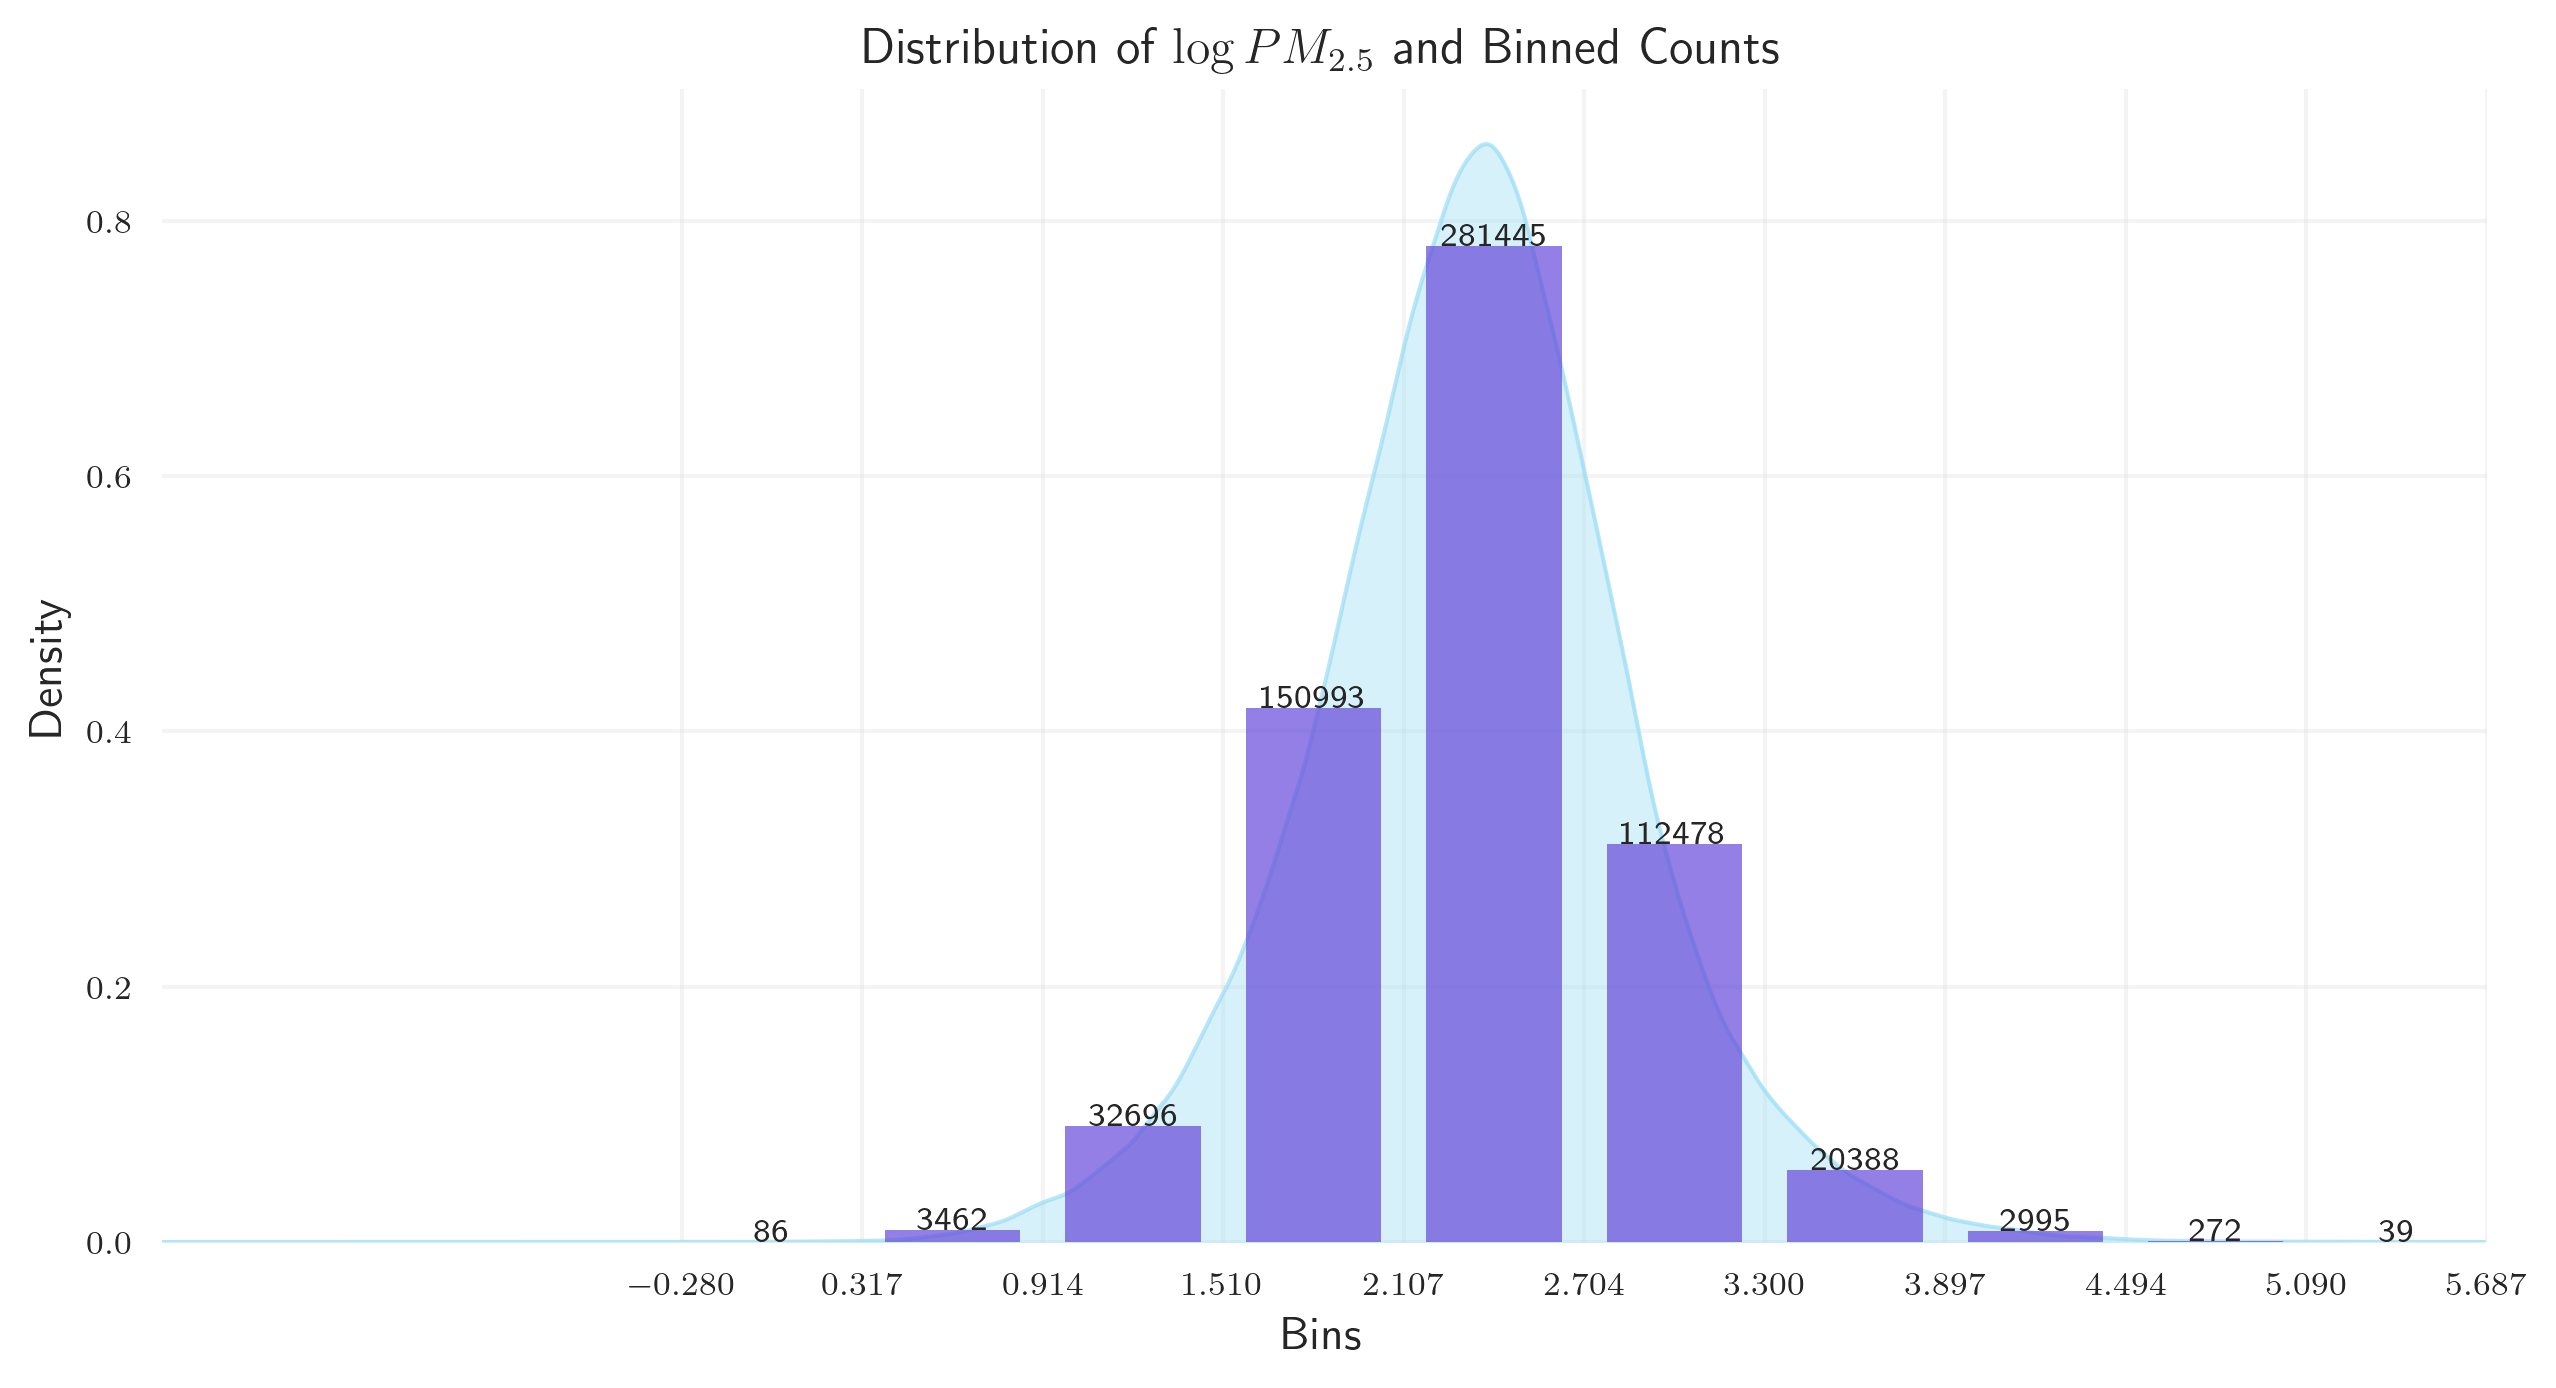

In [79]:
fig, ax = plt.subplots(dpi = 300, figsize=(10, 5.09))

bins = histogram_density_plot(train, 
                       by='PM2.5', 
                       nbins=10, 
                       title="Distribution of $\log PM_{2.5}$ and Binned Counts", 
                       tick_fontsize=8,
                       dpi=600,
                       xlabel='Bins',
                       ylabel='Density',
                       xmin=-2, 
                       ax=ax)

plt.savefig(os.path.join(paths.figures, 'distribution.png'))

In [129]:
val_results_file = os.path.join(paths.base, 'validation_predictions.csv')

if os.path.exists(val_results_file):
    predictions = pd.read_csv(val_results_file).set_index('time')
else:
    locations = val['lat'].astype(str) + val['lon'].astype(str)
    locations.name = 'Location'

    mc.lme_locations = locations

    preds = mc.predict(x_val)
    predictions = pd.DataFrame(preds, index=x_val.index)
    predictions = pd.concat([predictions, pd.DataFrame({'True Value': y_val}, index=x_val.index)], axis=1)
    predictions.to_csv(val_results_file)

In [150]:
scores = scores_from_model_collection_predictions(predictions)

In [151]:
print(scores.to_csv())

Model,R2,MAE,RMSE
Ada Boost,0.4445685799640886,0.33029368885926114,0.41888762730043855
Bayesian Ridge,0.553965122889097,0.2838835858607424,0.37537618875480183
Elastic Net,0.5550327967309188,0.28305090642490816,0.3749266505213094
Extra Trees,0.6494473864233212,0.2525741084015552,0.3327813013091857
Gradient Boost,0.6418314363351478,0.25450283836400117,0.33637680688423505
Linear Mixed Effect,0.5251930385281307,0.29076864642970746,0.38729407222837564
Linear Regression,0.5539595213835699,0.28388838727670124,0.3753785458184559
MLP,0.6735892171387635,0.24451959638798684,0.3211179329092191
MLP1,0.652828873713337,0.251451764382278,0.331172380763295
MLP2,0.6621712146442374,0.24751900666885276,0.326686085367778
MLP3,0.6561180876430127,0.2497440983009844,0.3295998289151308
Polynomial,0.6282061571772874,0.2602037707318356,0.3427152324042035
Random Forest,0.6557726768858541,0.24995515143460625,0.32976531995777547
SVR,0.5496980295992665,0.28326731399813426,0.37716747526838845
XGBoost,0.63990556934231

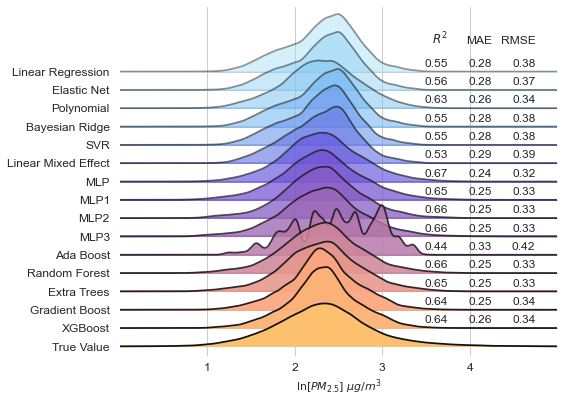

In [137]:
import joypy

fig, axes = joypy.joyplot(predictions, fade=True, colormap=announce, x_range=(0, 5), grid=True)

axes[-1].set_xlabel('$\ln[PM_{2.5}] ~ \mu g/m^3$')

ax = axes[0]
ax.text(0.75, .5, '$R^2$', ha='right', transform=ax.transAxes)
ax.text(0.85, .5, 'MAE', ha='right', transform=ax.transAxes)
ax.text(0.95, .5, 'RMSE', ha='right', transform=ax.transAxes)

for ax in axes[:-2]:
    model = ax.get_yticklabels()[0].get_text()
    perf = scores.loc[model]
    ax.text(0.75, .2, f'{perf["R2"]:.2f}', ha='right', transform=ax.transAxes)
    ax.text(0.85, .2, f'{perf["MAE"]:.2f}', ha='right', transform=ax.transAxes)
    ax.text(0.95, .2, f'{perf["RMSE"]:.2f}', ha='right', transform=ax.transAxes)

fig.savefig(os.path.join(paths.figures, 'densities.svg'), format='svg')

In [68]:
average_fit_times = {model: res['fit_time'].mean() for model, res in mc.cross_val_scores_.items()}
fit_times_error = {model: np.std(res['fit_time'], ddof=1) / np.sqrt(np.size(res['fit_time'])) for model, res in mc.cross_val_scores_.items()}

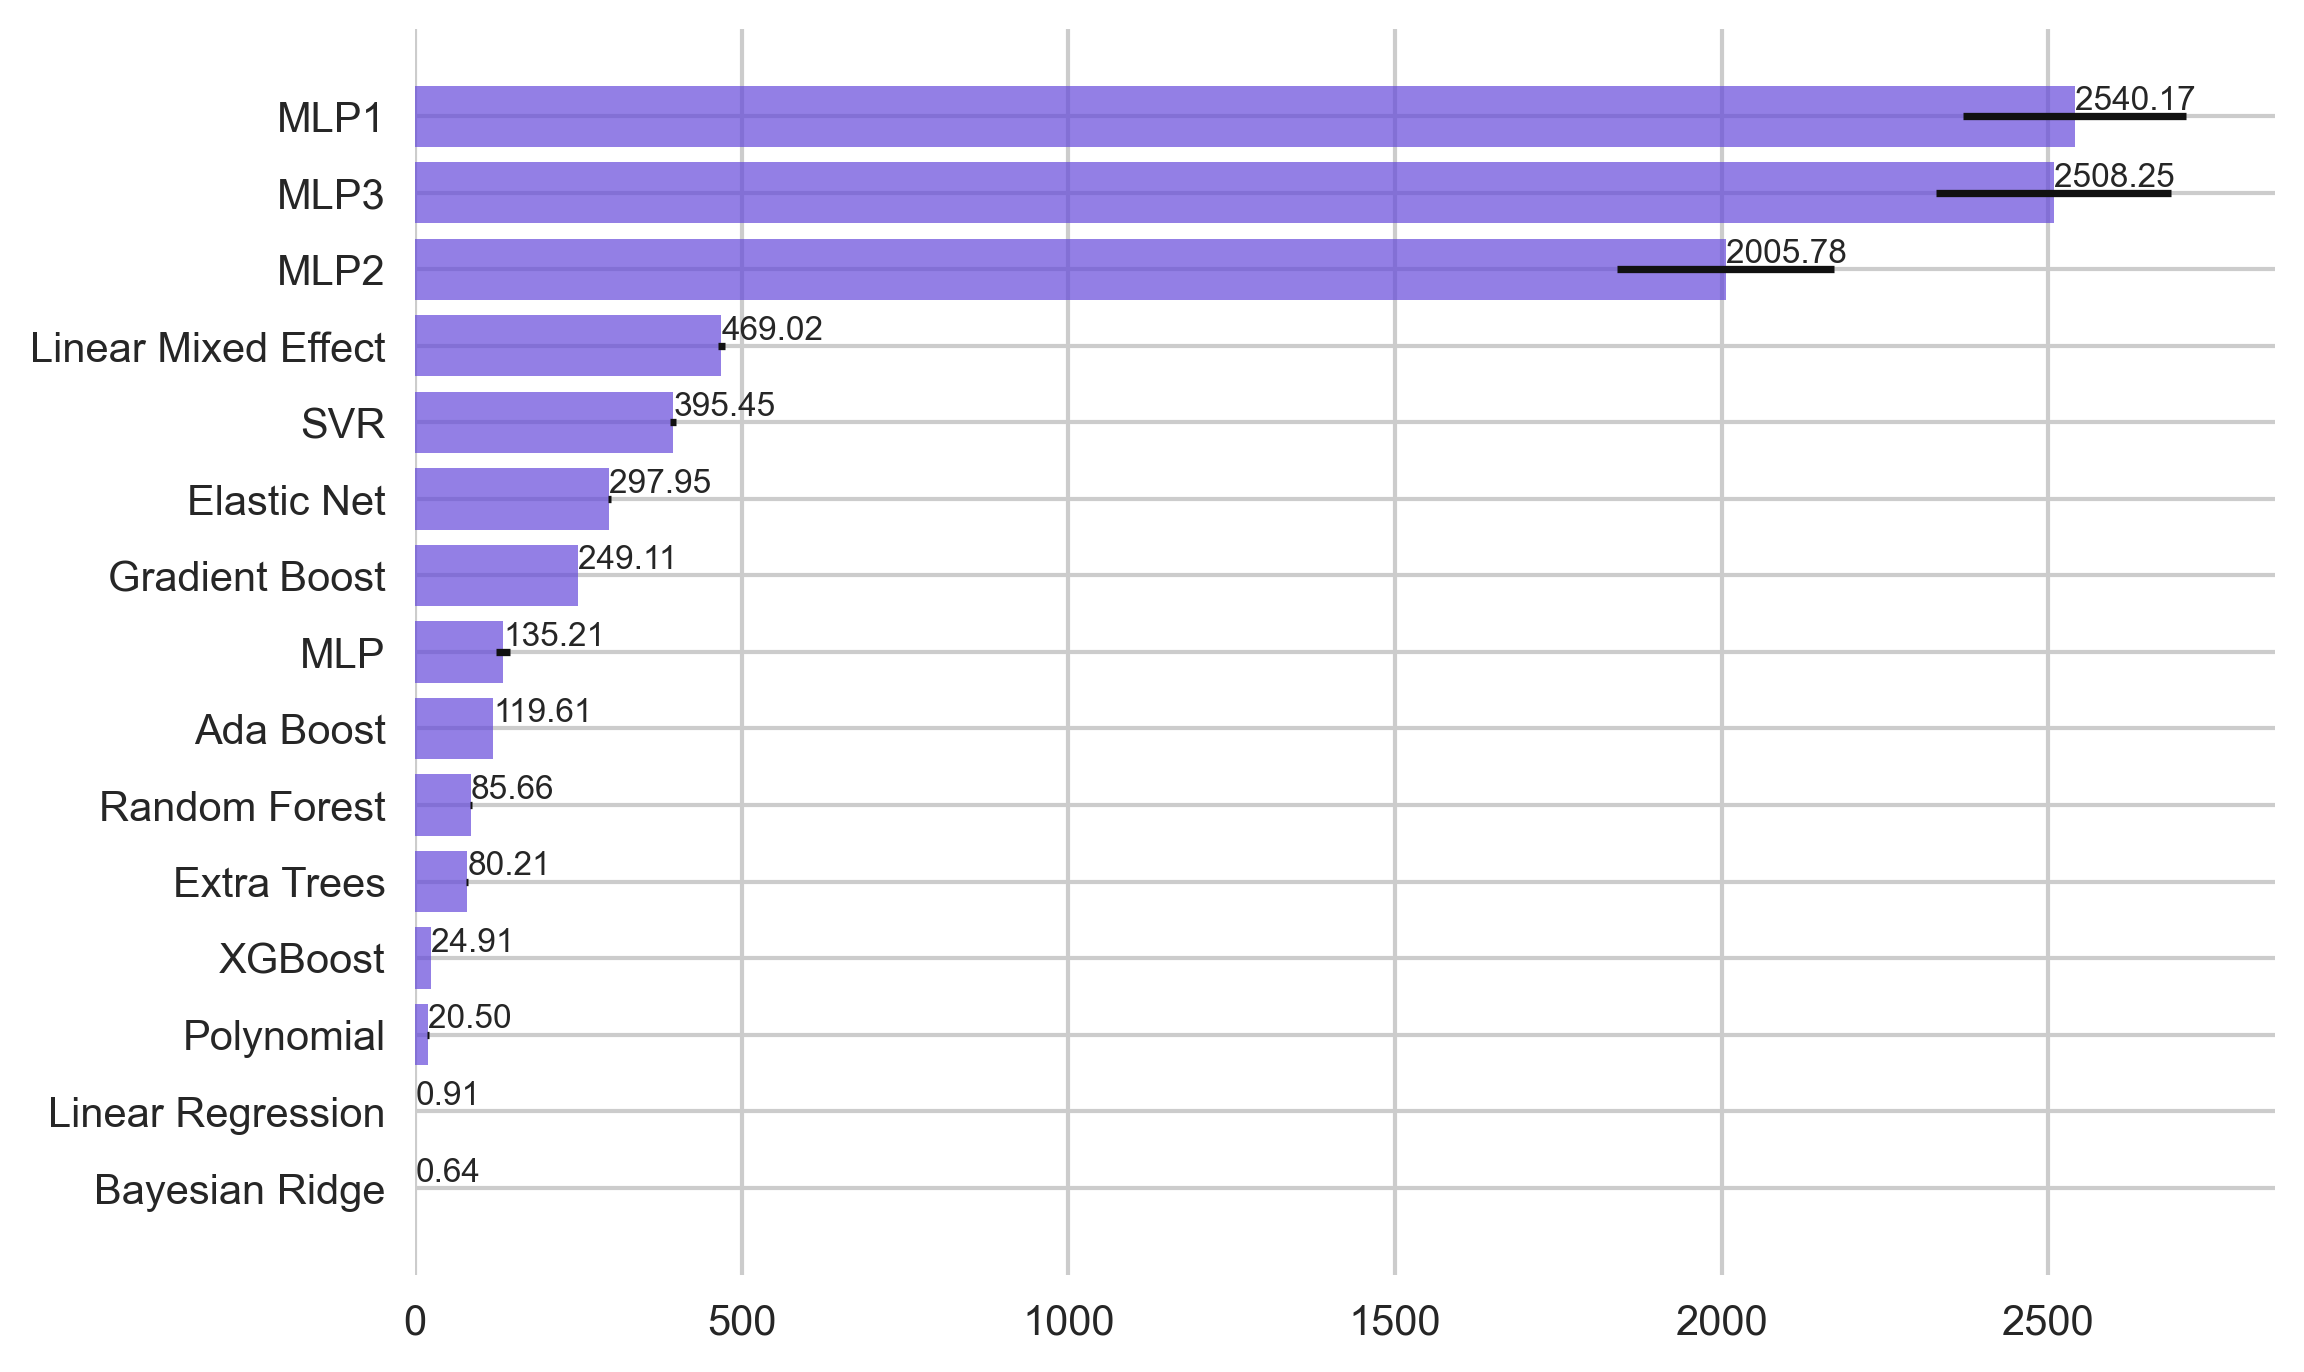

In [69]:
fig, ax = plt.subplots(dpi=300)

labels, values = map(np.array, zip(*average_fit_times.items()))
sort = np.argsort(values)

labels, values = labels[sort], values[sort]
xerr = np.array(list(fit_times_error.values()))[sort]

patches = ax.barh(labels, 
                  values, 
                  xerr=xerr,
                  alpha=0.7,
                  color='#6549DA')

for idx, patch in enumerate(patches):
    which = labels[idx]
    bl = patch.get_xy()
    x = patch.get_width() + bl[0] + .01
    y = 0.5*patch.get_height() + bl[1]
    ax.text(x, y, 
            f'{average_fit_times[which]:0.2f}', 
            fontsize=8, 
            ha='left',
            va='bottom')
    
fig.savefig(os.path.join(paths.figures, 'fit_times.svg'), format='svg', bbox_inches='tight')

In [95]:
gridded_results_file = os.path.join(paths.base, 'validation_results.nc4')

if os.path.exists(gridded_results_file):
    with xr.open_dataset(gridded_results_file) as results:
        results.load()
else:
    results = predictions.copy()
    results.index = pd.to_datetime(results.index)
    results[['lat', 'lon']] = val[['lat', 'lon']]
    results = results.reset_index().set_index(['lat', 'lon', 'time']).to_xarray()
    results = results.apply(np.exp)
    results.to_netcdf(gridded_results_file)

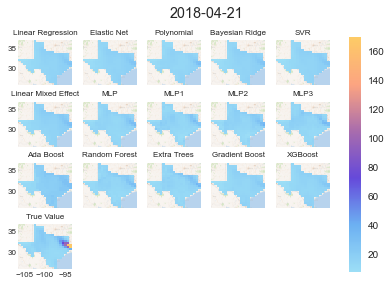

In [96]:
true = results['True Value']
max_pm_occurence = true.where(true==true.max(), drop=True).squeeze().time.values
ds = results.sel(time=max_pm_occurence)

fig_title = np.datetime_as_string(max_pm_occurence, unit='D')

fig, axes = map_predicted(ds, nrows=4, ncols=5, colormap=announce)

fig.suptitle(fig_title);
fig.savefig(os.path.join(experiment, 'figures', 'max_pm_with_predictions.svg'), format='svg', bbox_inches='tight')

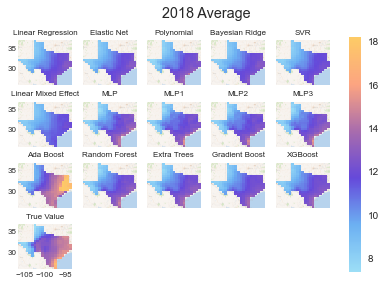

In [97]:
avg_2018 = results.resample(time="Y").mean().sel(time='2018')

fig_title = '2018 Average'

fig, axes = map_predicted(avg_2018, nrows=4, ncols=5, colormap=announce)

fig.suptitle(fig_title);
fig.savefig(os.path.join(paths.figures, '2018_average_predictions.svg'), format='svg', bbox_inches='tight')

In [205]:
def difference_from_true(ds):
    df = ds.to_dataframe().reset_index('time').dropna().drop(['time'], axis=1)
    true_series = df['True Value']
    df.drop(['True Value'], axis=1, inplace=True)
    
    cols = df.columns
    df[cols] = df[cols].sub(true_series.squeeze(), axis=0)
    return df.to_xarray()

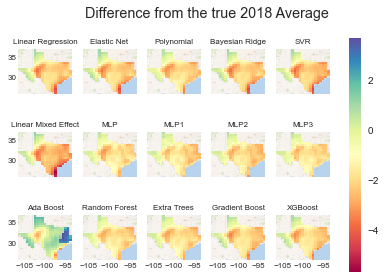

In [110]:
from matplotlib import cm
from palettable.colorbrewer.diverging import Spectral_11

fig_title = 'Difference from the true 2018 Average'

difference_from_true_2018 = difference_from_true(avg_2018)

fig, axes = map_predicted(difference_from_true_2018, nrows=3, ncols=5, colormap=Spectral_11.mpl_colormap)

fig.suptitle(fig_title);
fig.savefig(os.path.join(paths.figures, '2018_difference_from_true_mean.svg'), format='svg', bbox_inches='tight')

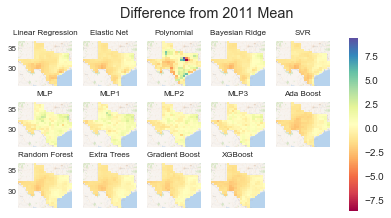

In [219]:
ds = grid_predictions.resample(time="Y").mean().apply(np.exp)

fig_title = 'Difference from 2011 Mean'

grid_model_difference = difference_from_true(ds)

fig, axes = map_predicted(grid_model_difference, nrows=4, ncols=5, colormap=Spectral_11.mpl_colormap)

fig.suptitle(fig_title);
fig.savefig(os.path.join(paths.figures, '2011_grid-by-grid_difference.svg'), format='svg', bbox_inches='tight')